In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit
import pandas as pd
import yaml
import sep
import scipy as sp
import pymc3 as pm

from matplotlib.patches import Rectangle, Ellipse, Circle
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
from tqdm import tqdm
from photutils import CircularAperture
from IPython.display import display
from MUSE_Models import PNe_residuals_3D, PNe_spectrum_extractor, PNextractor, PSF_residuals_3D, robust_sigma
from PNLF import open_data, reconstructed_image, completeness
from photutils import CircularAperture
from scipy.stats import norm, chi2
from scipy import stats
from ppxf_gal_L import ppxf_L_tot

from astroquery.vizier import Vizier
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils, wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext

# look into Pandas_profiling and cufflinks

%config InlineBackend.figure_format = 'retina'

In [54]:
gal_df = pd.read_csv("exported_data/galaxy_dataframe.csv")
pd.set_option('display.max_columns', 100)

gal_df["marker"] = ["o", "v", "<","3", ">", "8", "s", "p", "P", "*", "h", "H", "+","X", "x", "D", "d", ".", "o"] # 17

PN_filter  = (gal_df["PNe N"]>20) & pd.notnull(gal_df["alpha2.5"])


In [66]:
metal = np.array([-0.40255, -0.49004, -0.25009, -0.25928, -0.29124, -0.05275, -0.25394, -0.32663, 
                  -0.31608, -0.01729, -0.23269, -0.27237, -0.1244, -0.66811, -0.61946, -0.42180, 
                  -0.46046, -0.71112, -0.33854] )

metal_convers = 10**(metal)*0.19

In [19]:
ppxf_metals = np.array([-0.62, 0.386, 0.051, -0.947, -0.495, -0.072, -0.00826, -1.28, -0.96,
                        -0.268, -0.899, -0.0321,-1.11, -0.196, -0.53, -0.541, -0.835, -0.306, -1.01])

ppxf_metal_convers = 10**(ppxf_metals)*0.19

In [30]:
lit_gal_df = pd.read_csv("exported_data/lit_galaxy_df.csv")

## Make LaTex table for cataolgue paper

In [3]:
latex_table = pd.DataFrame()


gal_table = Table([gal_df["Galaxy"], gal_df["PNe N"], 
                   [f"{n} $\pm$ {e}" for n,e in zip(round(gal_df["PNLF N"]), round(gal_df["N err"]))], 
                   [f"${L}"+"^{+"+f"{u}"+"}"+f"_{ {-l} }$" for L,u,l in zip((gal_df["Lbol"]/1e9).round(2), (gal_df["Lbol p"]/1e9).round(2), (gal_df["Lbol m"]/1e9).round(2))],
                   [f"${a}"+"^{+"+f"{u}"+"}"+f"_{ {-l} }$" for a,u,l in zip((gal_df["alpha2.5"]/1e-8).round(2), (gal_df["alpha2.5 err up"]/1e-8).round(2), (gal_df["alpha2.5 err lo"]/1e-8).round(2))], 
                   [f"{D} $\pm$ {e}" for D,e in zip(gal_df["D PNLF"].round(2), gal_df["D PNLF err"].round(2))], 
                   [f"{D} $\pm$ {e}" for D,e in zip(gal_df["dM PNLF"].round(2),gal_df["dM PNLF err"].round(2))]],
                   names=("Galaxy", "$N_{PNe}$", "$N_{PNLF}$", "$L_{bol}$", "$ alpha_{2.5}$",
                          "$D_{PNLF}$", "$\mu_{PNLF}$"))

# Save latex table of data.
ascii.write(gal_table, f"exported_data/galaxy_df_latex.txt", format="latex", overwrite=True) 

In [142]:
gal_df.iloc[12]

Unnamed: 0                      12
Unnamed: 0.1                    12
Galaxy                      FCC219
D PNLF                        19.2
D PNLF err                    0.87
dM PNLF                      31.42
dM PNLF err                  0.099
PNe N                           62
PNLF N                         323
N err                       41.021
Lbol                   2.70354e+10
lit Lbol               1.36828e+10
alpha2.5               1.19473e-08
alpha2.5 err up        1.81675e-09
alpha2.5 err lo        1.90172e-09
age                           11.7
FUV                            NaN
FUV err                        NaN
NUV                            NaN
NUV err                        NaN
Vmag                         10.65
Rmag                          10.2
Bmag                           NaN
sigma                          154
M/H                           0.14
Mg/Fe                         0.18
Lbol p                 2.56795e+09
Lbol m                 2.24064e+09
lit Rmag            

In [18]:
print(gal_df.iloc[11]["Galaxy"])
print(gal_df.iloc[11]["PNe N"])

print(gal_df.iloc[11]["D PNLF"])
print(gal_df.iloc[11]["D PNLF err"])
print(gal_df.iloc[11]["dM PNLF"])
print(gal_df.iloc[11]["dM PNLF err"])
print(gal_df.iloc[11]["PNLF N"])
print(gal_df.iloc[11]["N err"])
print(gal_df.iloc[11]["Lbol"])
print(gal_df.iloc[11]["Lbol p"])
print(gal_df.iloc[11]["Lbol m"])
print(gal_df.iloc[11]["alpha2.5"])
print(gal_df.iloc[11]["alpha2.5 err up"])
print(gal_df.iloc[11]["alpha2.5 err lo"])

FCC219
62
19.2
0.87
31.42
0.099
323.0
41.02104102106153
27035367017.61248
2567953900.757797
2240640279.9517326
1.1947313302222906e-08
1.8167485724120289e-09
1.901722875369446e-09


In [19]:
print(gal_df.iloc[5]["Galaxy"])
print(gal_df.iloc[5]["PNe N"])

print(gal_df.iloc[5]["D PNLF"])
print(gal_df.iloc[5]["D PNLF err"])
print(gal_df.iloc[5]["dM PNLF"])
print(gal_df.iloc[5]["dM PNLF err"])
print(gal_df.iloc[5]["PNLF N"])
print(gal_df.iloc[5]["N err"])
print(gal_df.iloc[5]["Lbol"])
print(gal_df.iloc[5]["Lbol p"])
print(gal_df.iloc[5]["Lbol m"])
print(gal_df.iloc[5]["alpha2.5"])
print(gal_df.iloc[5]["alpha2.5 err up"])
print(gal_df.iloc[5]["alpha2.5 err lo"])

FCC167
98
17.88
0.92
31.26
0.11
293.0
29.597469555379767
17384556487.65414
1891411678.3607788
1562764857.621416
1.6854039400319334e-08
2.4433722967388656e-09
2.3492741161023434e-09


In [24]:
# Compare M* using derived distances for each galaxy, against metallcity, UV, age etc.

# open the correct PNe_df for the galaxy, and find brightest PN used for distance.
m_star = np.ones((len(gal_df),3)) # m_star, m_star_up, m_star_lo

for i, gal in enumerate(gal_df["Galaxy"]):
    PNe_df = pd.read_csv(f"exported_data/{gal}/{gal}_PNe_df.csv")
    p_n = int(PNe_df.loc[PNe_df["Filter"]=="Y"].nsmallest(3, "m 5007").index.values[0])
    m_star[i,0] = PNe_df["m 5007"].iloc[p_n]
    m_star[i,1] = PNe_df["mag error up"].iloc[p_n]
    m_star[i,2] = PNe_df["mag error lo"].iloc[p_n]

# convert m_star to M_star
M_star = np.ones_like(m_star) # M_star, M_star_up, M_star_lo
for i, (dM, dM_err) in enumerate(zip(gal_df["lit dM"], gal_df["lit dM err"])):
    M_star[i,0] = m_star[i,0] - dM
    M_star[i,1] = np.sqrt((m_star[i,1]**2) + (dM_err**2))
    M_star[i,2] = np.sqrt((m_star[i,2]**2) + (dM_err**2))
    
print(M_star)


[[-4.6501748   0.24507643  0.24313783]
 [-3.64268042  0.28825251  0.25695003]
 [-4.76318272  0.26479048  0.25092619]
 [-4.12857263  0.25700506  0.24981628]
 [-4.27814121  0.24413838  0.24388918]
 [-4.61775024  0.16933241  0.16296972]
 [-4.75823669  0.31702226  0.2972196 ]
 [-4.43912404  0.6204634   0.32932441]
 [-4.12905282  0.28929625  0.28319839]
 [-4.25358084  0.37425512  0.32576171]
 [-4.21891272  0.32075051  0.29781248]
 [-4.42382977  0.22180522  0.22135475]
 [-4.48330972  0.22739013  0.22544021]
 [-4.68286674  0.31654079  0.27027445]
 [-4.30817122  0.28197441  0.28120102]
 [-5.07120737  0.22894746  0.22487521]
 [-4.41791203  0.29102349  0.28642838]
 [-4.55803799  0.27176955  0.25392334]
 [-4.37406478  0.28722187  0.28469747]]


Median M* -4.423829774888432


Text(0, 0.5, '$M^{*}_{5007}$')

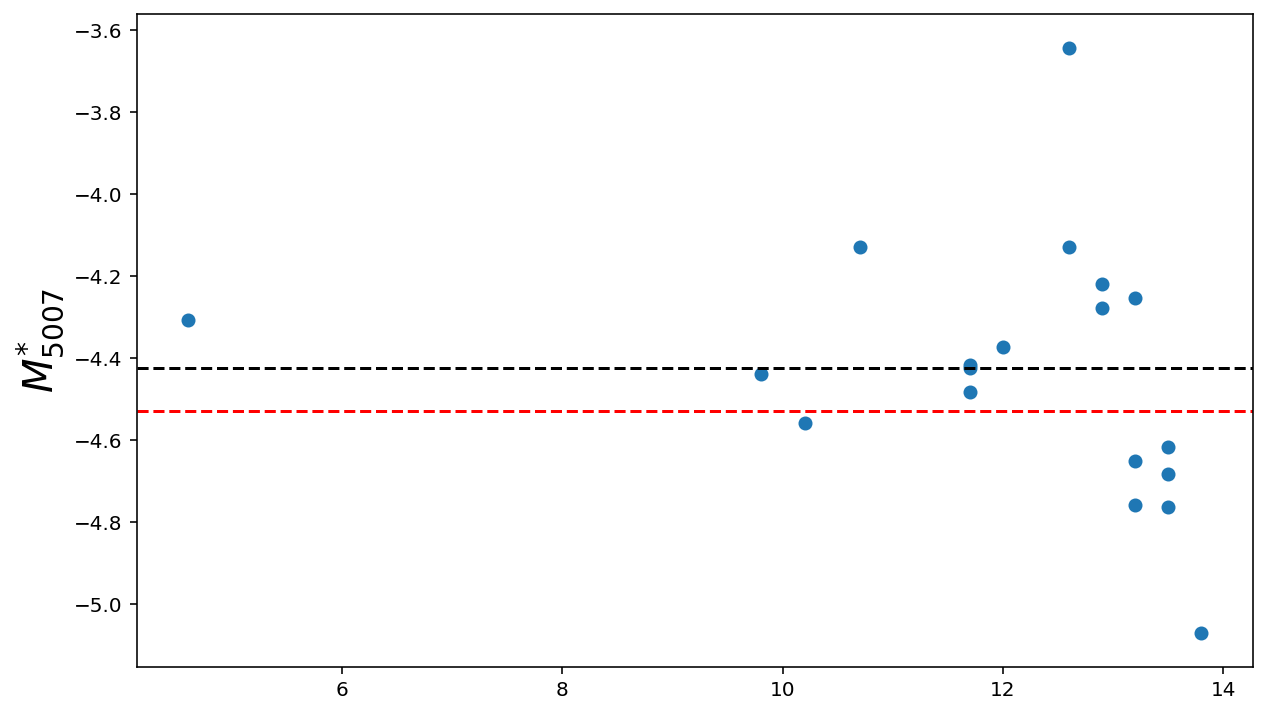

In [200]:
plt.figure(figsize=(10,6))
plt.scatter(gal_df["age"].loc[PN_filter], M_star[:,0][PN_filter])#, c=gal_df["Mg/Fe"].loc[PN_filter].values)
# plt.scatter(ppxf_metals[PN_filter], M_star[:,0][PN_filter])#, c=gal_df["Mg/Fe"].loc[PN_filter].values)
# plt.colorbar()
plt.axhline(np.median(M_star[:,0]), c="k", ls="--")
print(f"Median M* {np.median(M_star[:,0])}")
# plt.errorbar(gal_df["Mg/Fe"].loc[PN_filter], M_star[:,0][PN_filter], yerr=[M_star[:,2][PN_filter],M_star[:,1][PN_filter]], ls="None")
plt.axhline(-4.53, c="r", ls="--")
plt.ylabel(r"$M^{*}_{5007}$", fontsize=20)
# plt.xlim(9,14)

Text(0.5, 0, '$\\Delta dM$')

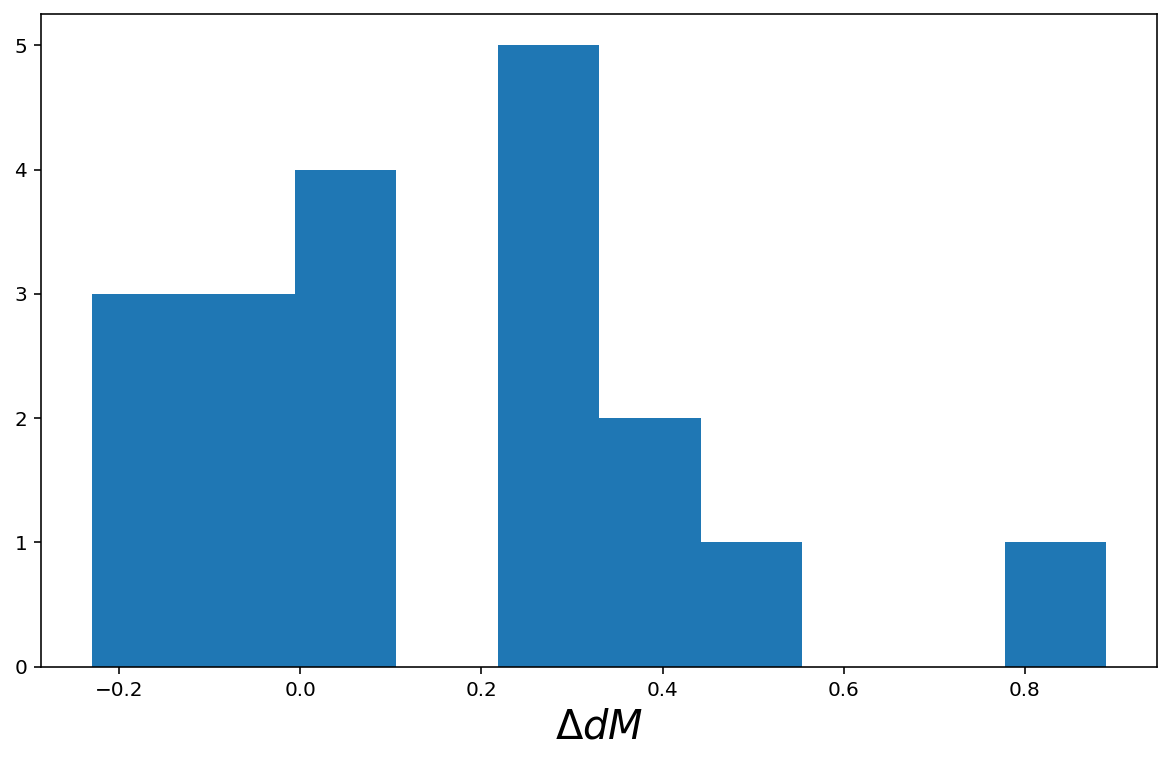

In [14]:
plt.figure(figsize=(10,6))
# plt.scatter(gal_df["PNe N"], gal_df["dM PNLF"] - gal_df["lit dM"], c=gal_df["log alpha2.5"])
# plt.axhline(0)
plt.hist(gal_df["dM PNLF"] - gal_df["lit dM"])
# plt.axhline(-4.53, ls="--")
plt.xlabel(r"$\Delta dM$", fontsize=20)

Text(0, 0.5, 'log10 alpha2.5')

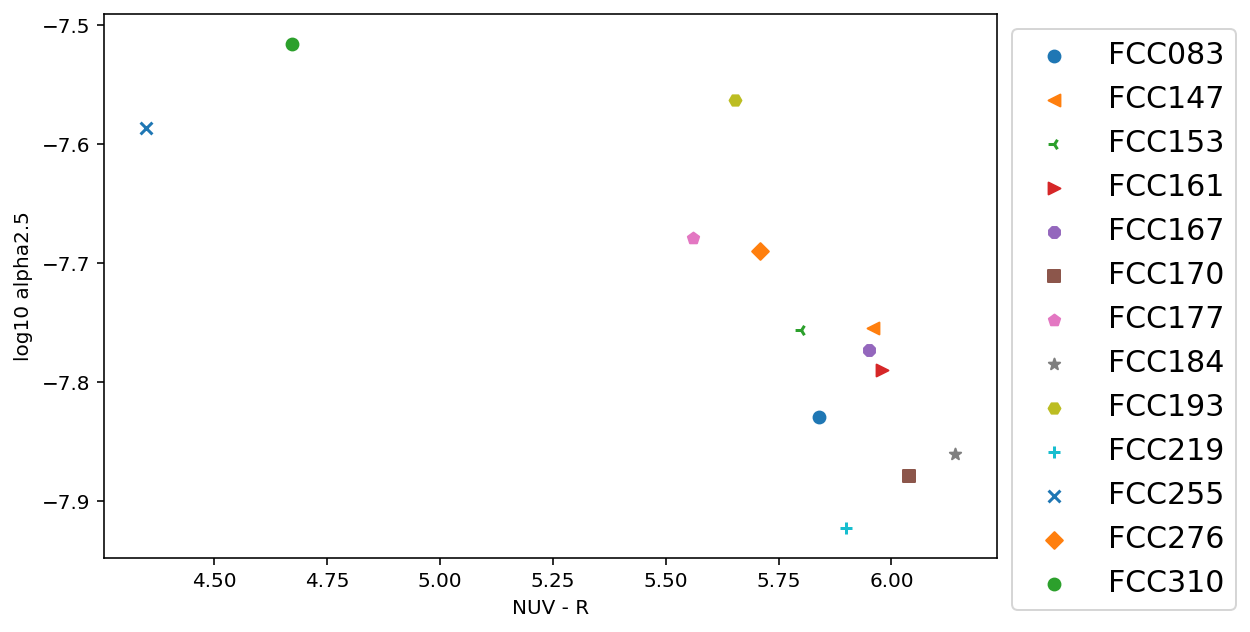

In [48]:
plt.figure(figsize=(8,5))

for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["GALEX NUV"].loc[PN_filter]-gal_df["Rmag"].loc[PN_filter],gal_df["log alpha2.5"].loc[PN_filter]):
    plt.scatter(x_d,y_d, marker=gal_df.loc[gal, "marker"], s=35, label=gal_df.loc[gal, "Galaxy"])
    
ax = plt.gca()
plt.legend(bbox_to_anchor=(1., 1.), fontsize=15)
plt.xlabel("NUV - R")
plt.ylabel("log10 alpha2.5")

# plt.savefig("Plots/FUV-NUV_vs_alpha.png", bbox_inches="tight")

Text(0, 0.5, 'GALEX FUV - NUV')

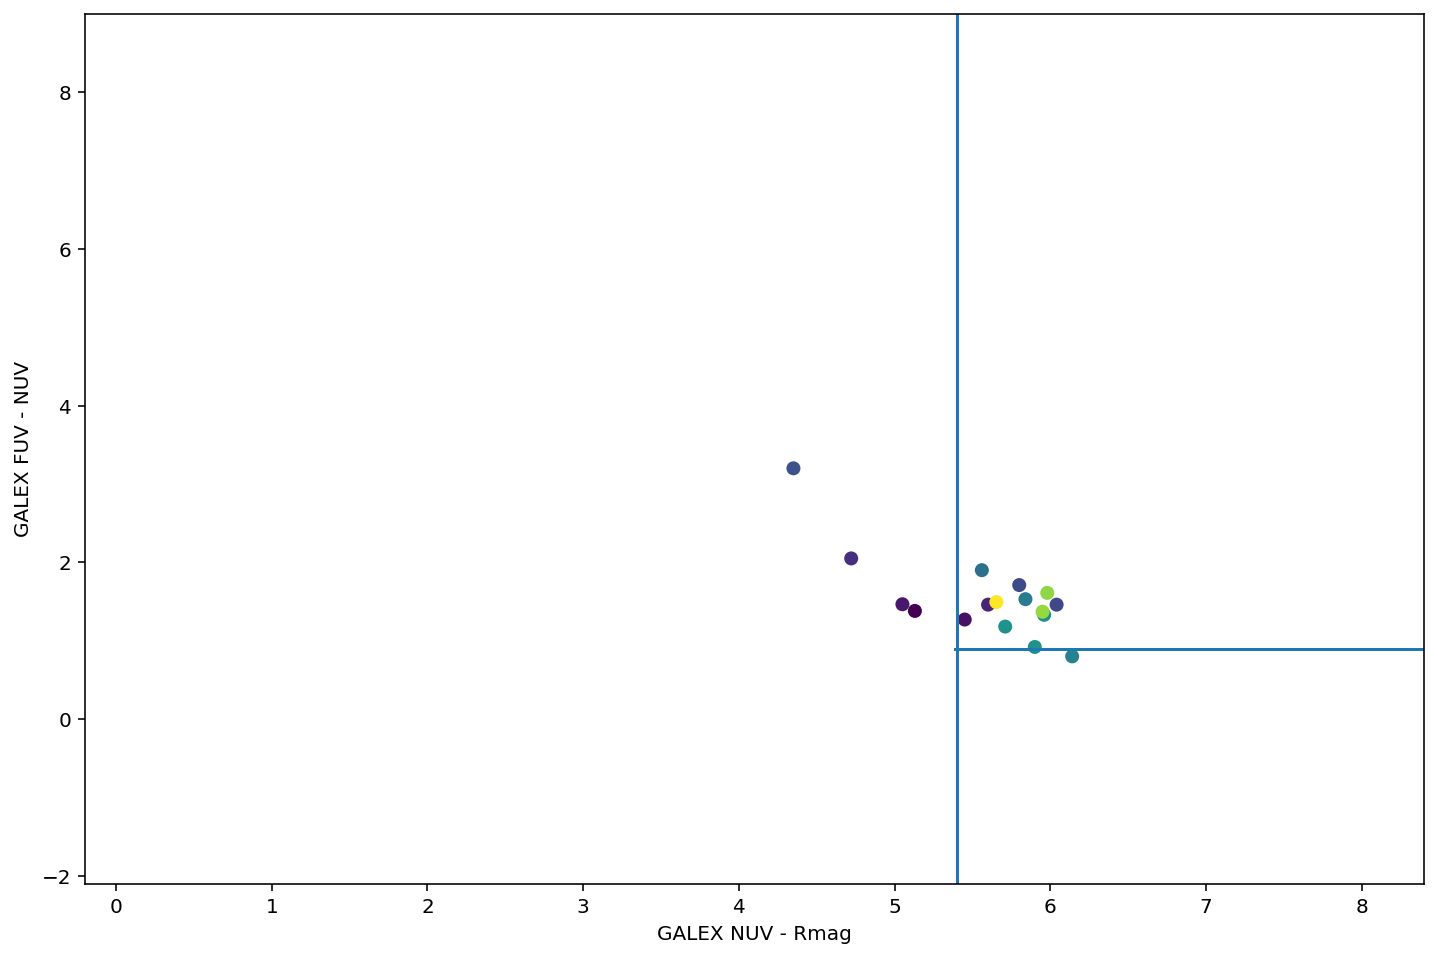

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(gal_df["GALEX NUV"]-gal_df["Rmag"], gal_df["GALEX FUV"]-gal_df["GALEX NUV"], c=gal_df["PNe N"])
plt.ylim(-2.1, 9)
plt.xlim(-0.2, 8.4)
plt.axvline(5.4)
plt.axhline(0.9, xmin=0.65)
plt.xlabel("GALEX NUV - Rmag")
plt.ylabel("GALEX FUV - NUV")

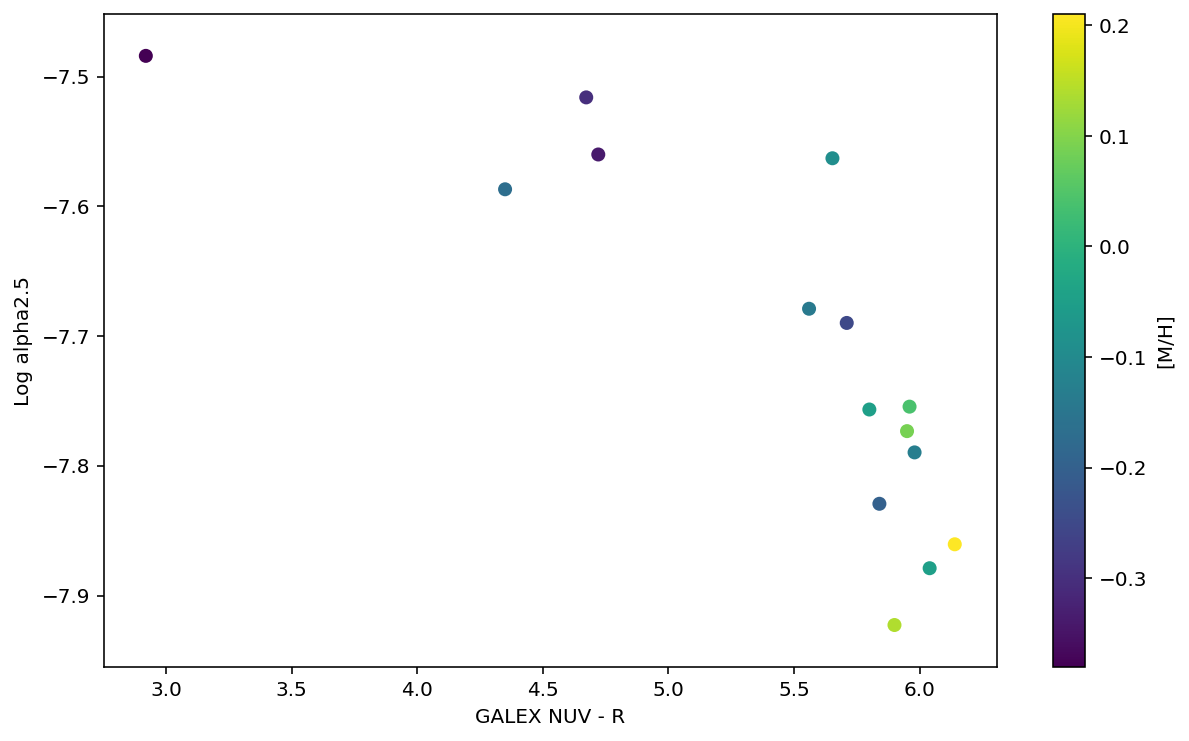

In [56]:
plt.figure(figsize=(10,6))
plt.scatter(gal_df["GALEX NUV"].loc[PN_filter]-gal_df["Rmag"].loc[PN_filter], gal_df["log alpha2.5"].loc[PN_filter], c=gal_df["M/H"].loc[PN_filter])#metal[PN_filter])
# plt.scatter(gal_df["GALEX FUV"].loc[PN_filter]-gal_df["GALEX NUV"].loc[PN_filter], gal_df["GALEX FUV"].loc[PN_filter]-gal_df["Rmag"].loc[PN_filter], c=gal_df["M/H"].loc[PN_filter])#metal[PN_filter])
plt.xlabel("GALEX NUV - R")
plt.ylabel("Log alpha2.5")
cb = plt.colorbar()
cb.set_label("[M/H]")

In [122]:
# sp.stats.spearmanr(a=gal_df["M/H"].loc[PN_filter], b=gal_df["log alpha2.5"].loc[PN_filter])
sp.stats.spearmanr(a=gal_df["GALEX FUV"].loc[PN_filter]-gal_df["GALEX NUV"].loc[PN_filter], b=gal_df["log alpha2.5"].loc[PN_filter], nan_policy="omit")

SpearmanrResult(correlation=0.6643356643356644, pvalue=0.018452718028445437)

Text(0, 0.5, '$Log_{10}(\\alpha_{2.5})$')

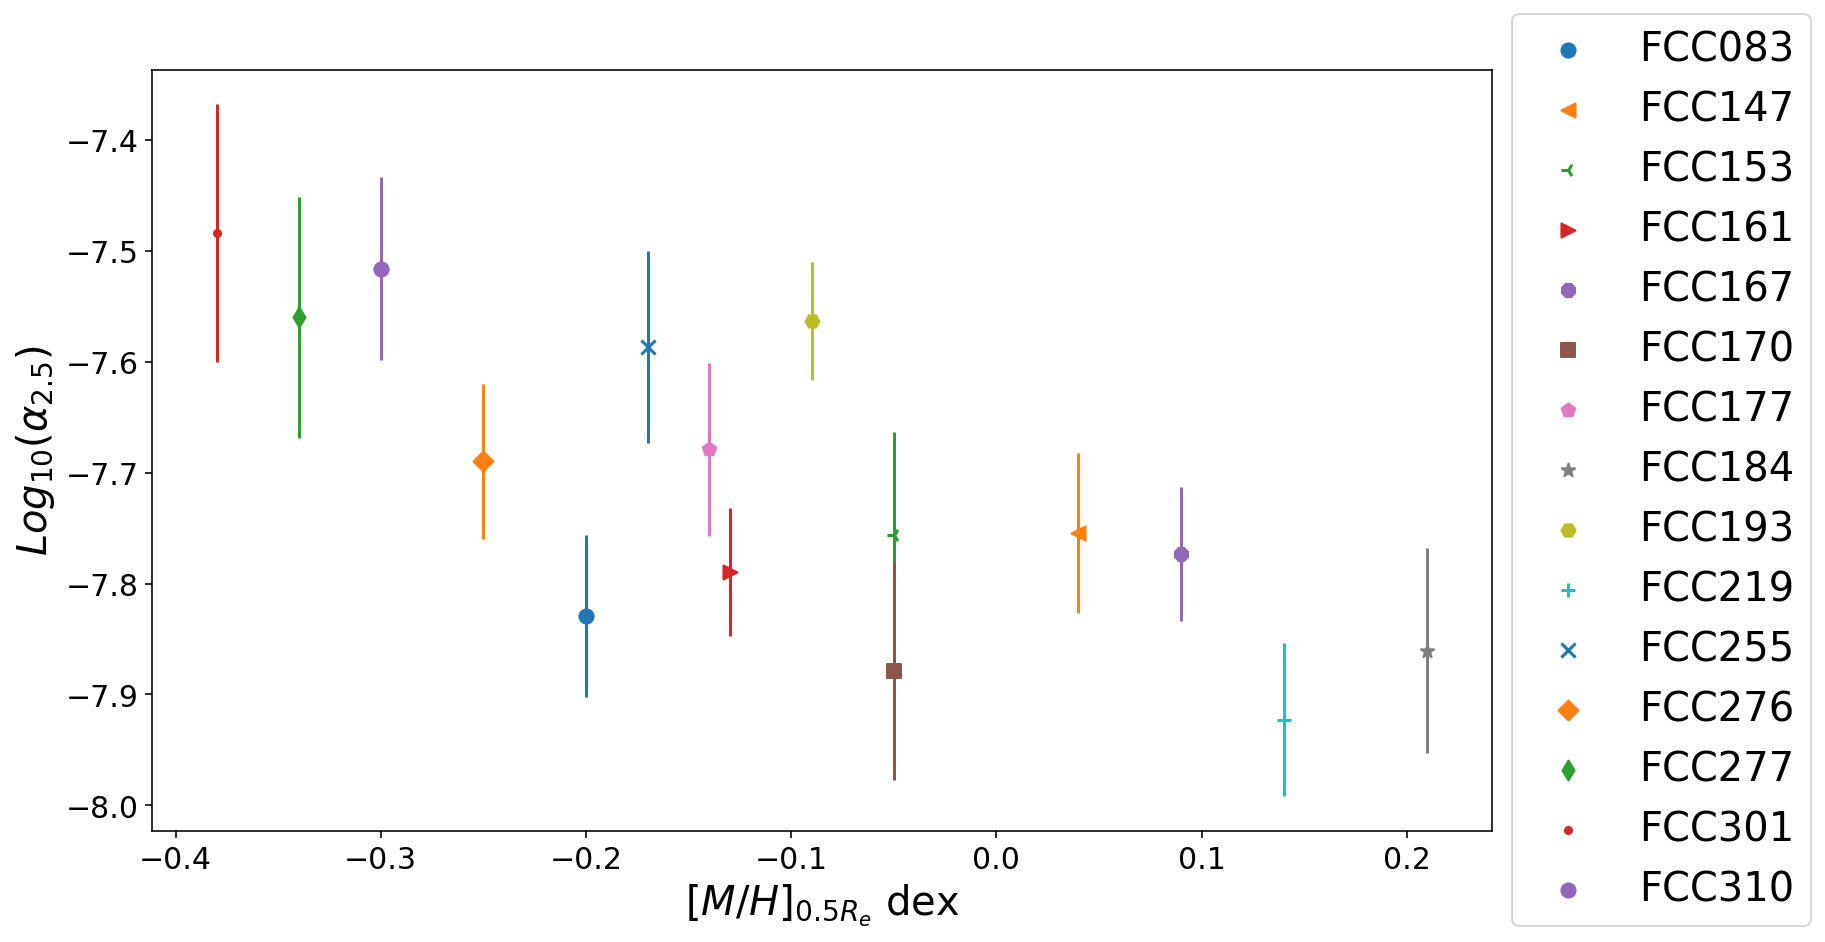

In [55]:
# PNLF Distance
plt.figure(figsize=(12,7))

for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["M/H"].loc[PN_filter],gal_df["log alpha2.5"].loc[PN_filter]):
    plt.scatter(x_d, y_d, marker=gal_df.loc[gal, "marker"], s=50, label=gal_df.loc[gal, "Galaxy"])
    plt.errorbar(x=x_d, y=y_d, yerr=[[gal_df["log alpha2.5 err lo"].iloc[gal]], [gal_df["log alpha2.5 err lo"].iloc[gal]]], ls="None")
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
f_size=20
plt.legend(bbox_to_anchor=(1., 1.1), fontsize=f_size)
plt.xlabel(r"$[M/H]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)

# plt.savefig("Plots/alpha_vs_MH.png", bbox_inches='tight')

Text(0, 0.5, '$Log_{10}(\\alpha_{2.5})$')

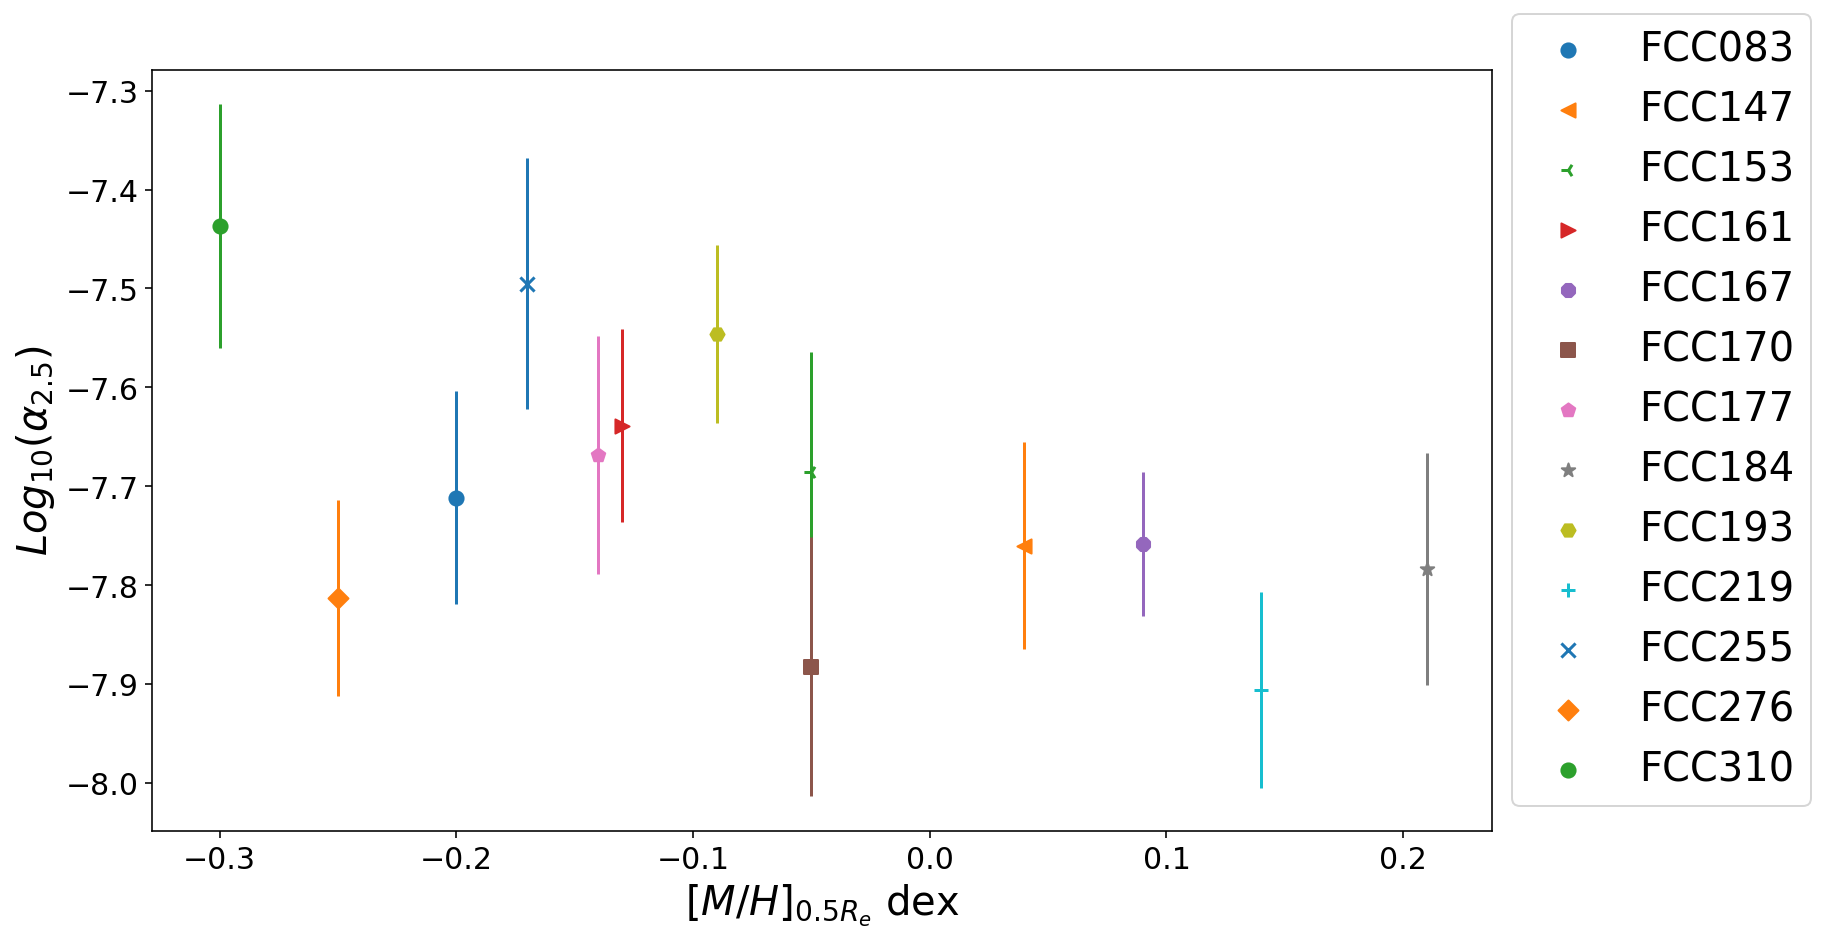

In [46]:
# lit Distance
plt.figure(figsize=(12,7))

for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["M/H"].loc[PN_filter],lit_gal_df["lit log alpha2.5"].loc[PN_filter]):
    plt.scatter(x_d, y_d, marker=gal_df.loc[gal, "marker"], s=50, label=gal_df.loc[gal, "Galaxy"])
    plt.errorbar(x=x_d, y=y_d, yerr=[[lit_gal_df["lit log alpha2.5 err lo"].iloc[gal]], [lit_gal_df["lit log alpha2.5 err lo"].iloc[gal]]], ls="None")
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
f_size=20
plt.legend(bbox_to_anchor=(1., 1.1), fontsize=f_size)
plt.xlabel(r"$[M/H]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
# plt.savefig("Plots/alpha_vs_MH.png", bbox_inches='tight')

In [62]:
gal_df.loc[3, "Mass"]

7600000000.0

Text(0, 0.5, '$Log_{10}(\\alpha_{2.5})$')

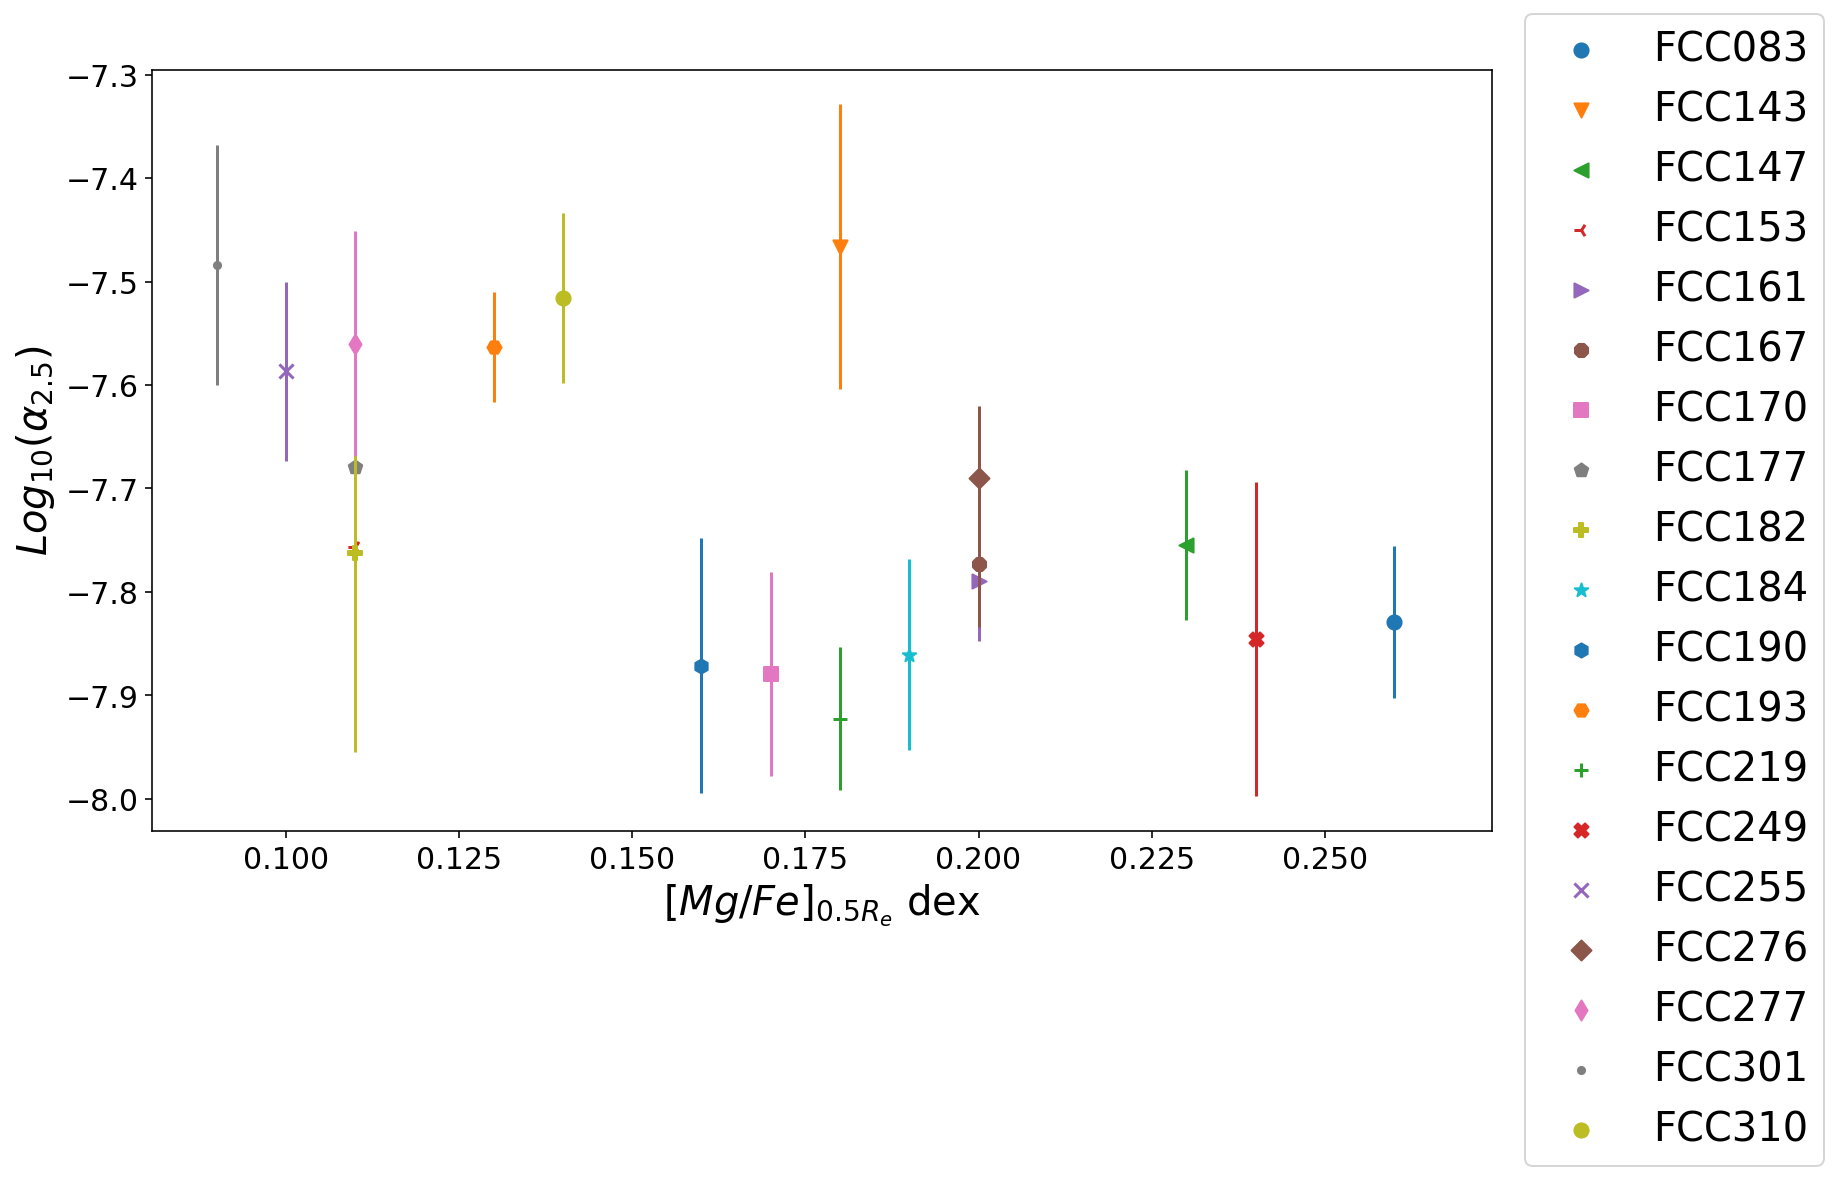

In [52]:
# PNLF Distance
plt.figure(figsize=(12,7))

for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["Mg/Fe"].loc[PN_filter],gal_df["log alpha2.5"].loc[PN_filter]):
    plt.scatter(x_d, y_d, marker=gal_df.loc[gal, "marker"], s=50, label=gal_df.loc[gal, "Galaxy"])
    plt.errorbar(x=x_d, y=y_d, yerr=[[gal_df["log alpha2.5 err lo"].iloc[gal]], [gal_df["log alpha2.5 err lo"].iloc[gal]]], ls="None")
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
f_size=20
plt.legend(bbox_to_anchor=(1.01, 1.1), fontsize=f_size)
plt.xlabel(r"$[Mg/Fe]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
# plt.savefig("Plots/alpha_vs_MgFe.png", bbox_inches='tight')

Text(0, 0.5, '$Log_{10}(\\alpha_{2.5})$')

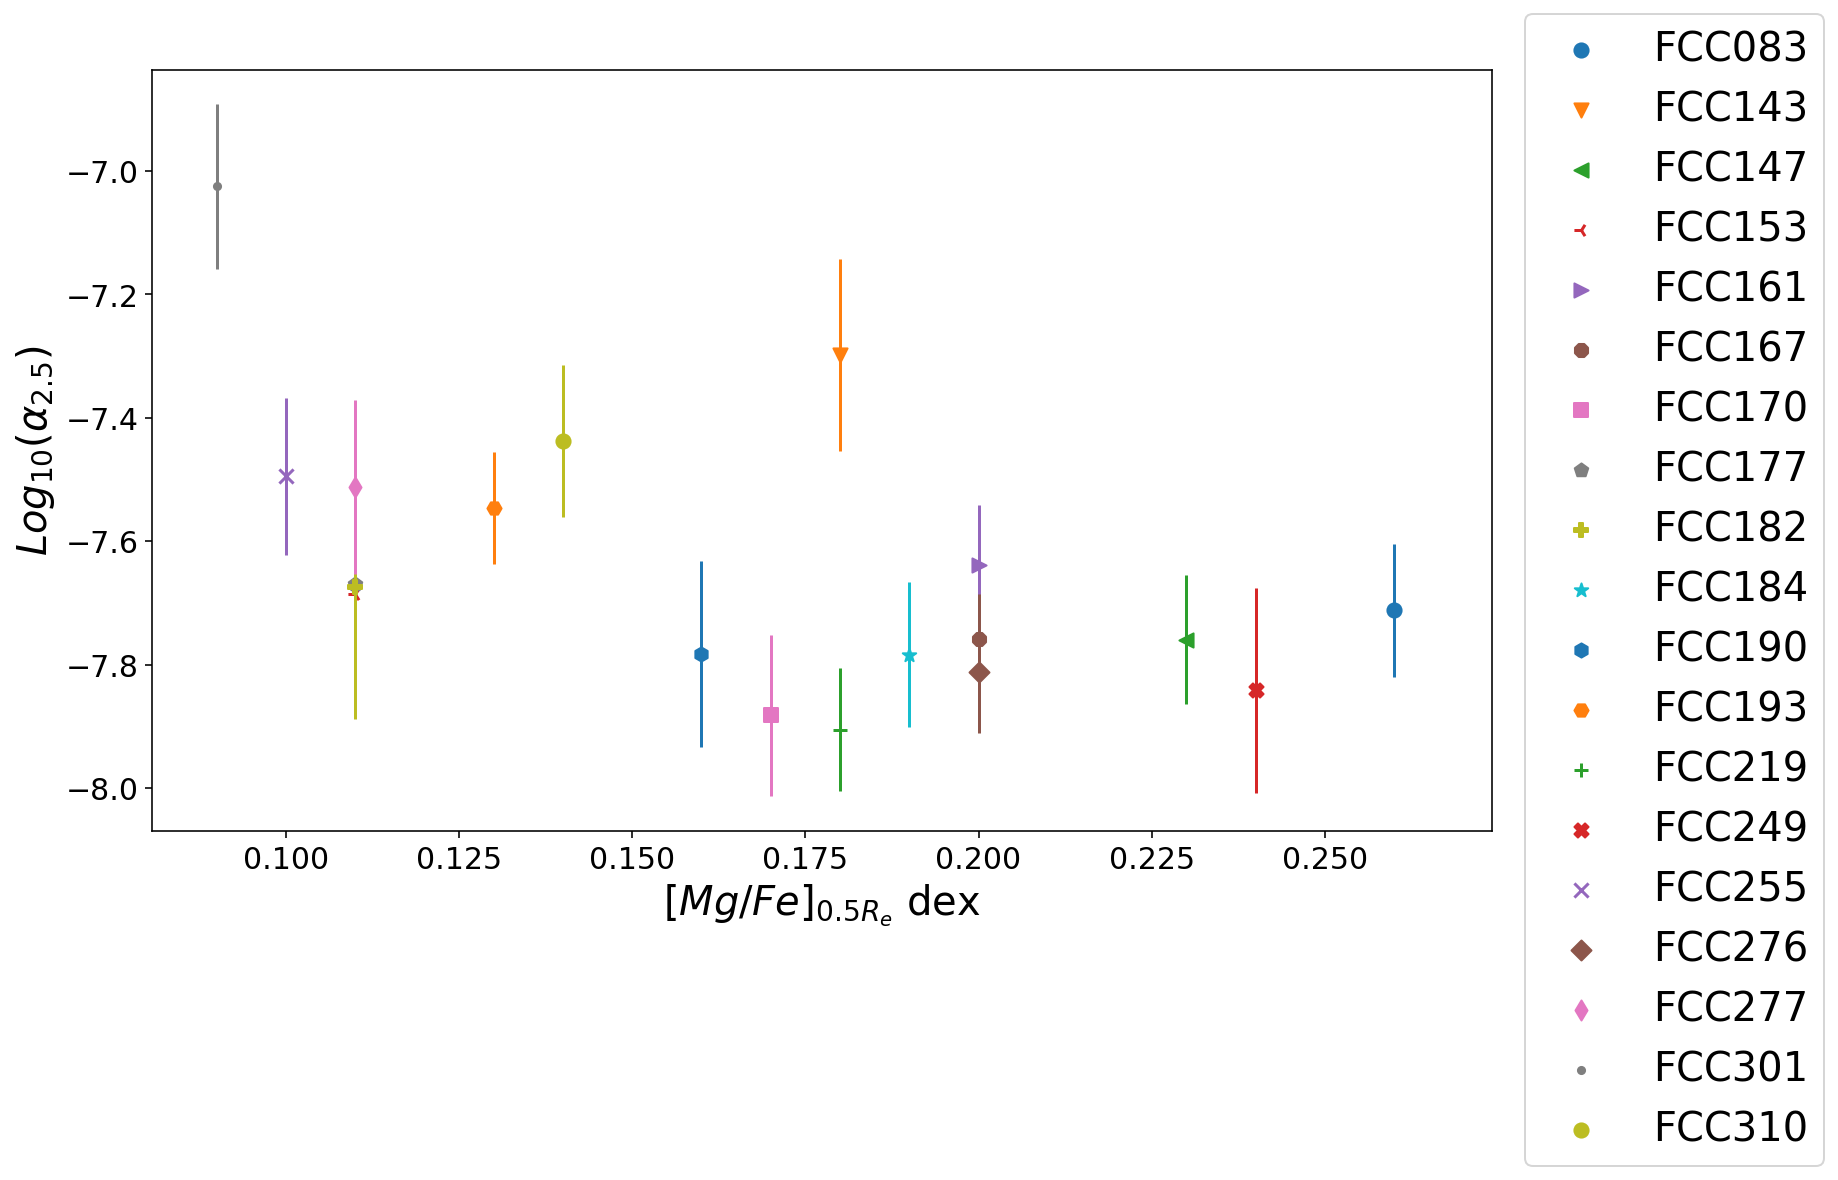

In [180]:
# lit Distance
plt.figure(figsize=(12,7))

for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["Mg/Fe"].loc[PN_filter],lit_gal_df["lit log alpha2.5"].loc[PN_filter]):
    plt.scatter(x_d, y_d, marker=gal_df.loc[gal, "marker"], s=50, label=gal_df.loc[gal, "Galaxy"])
    plt.errorbar(x=x_d, y=y_d, yerr=[[lit_gal_df["lit log alpha2.5 err lo"].iloc[gal]], [lit_gal_df["lit log alpha2.5 err lo"].iloc[gal]]], ls="None")
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
f_size=20
plt.legend(bbox_to_anchor=(1.01, 1.1), fontsize=f_size)
plt.xlabel(r"$[Mg/Fe]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
# plt.savefig("Plots/alpha_vs_MgFe.png", bbox_inches='tight')

Text(0, 0.5, '$Log_{10}(\\alpha_{2.5})$')

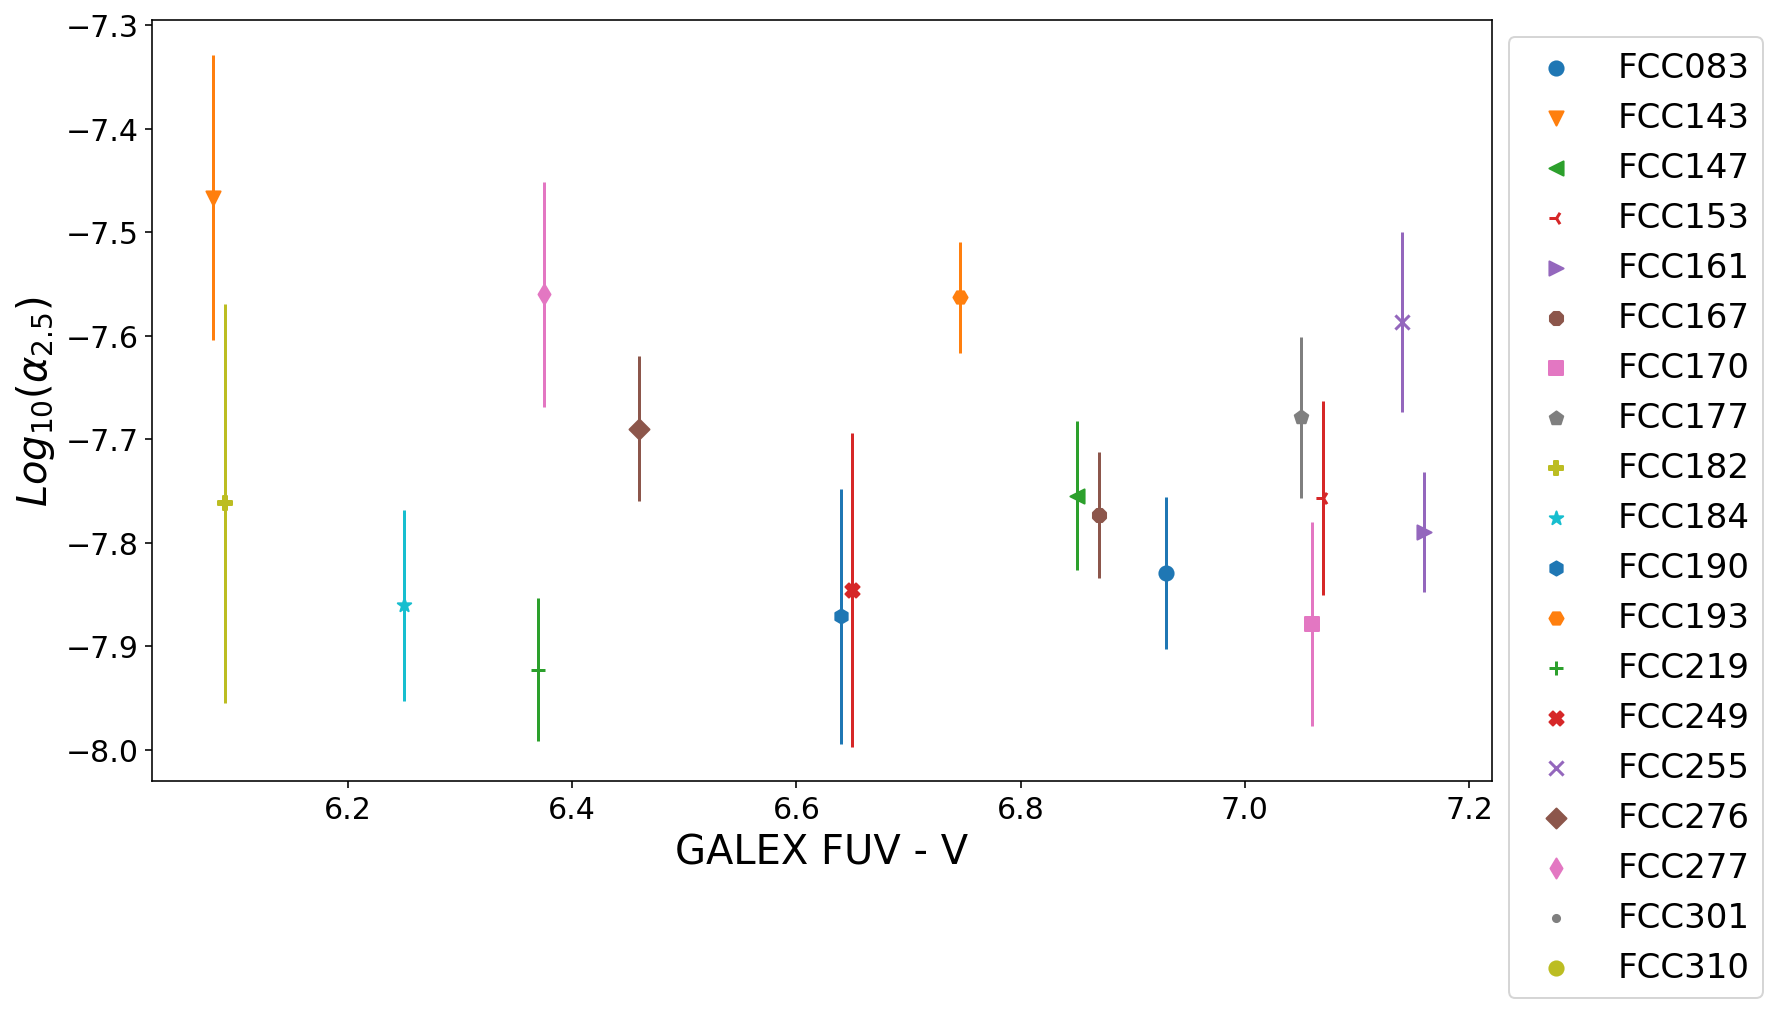

In [53]:
# PNLF Distance
plt.figure(figsize=(12,7))

# for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["GALEX_FUV"].loc[PN_filter]-gal_df["Rmag"].loc[PN_filter],gal_df["log alpha2.5"].loc[PN_filter]):
for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["GALEX FUV"].loc[PN_filter]-gal_df["Vmag"].loc[PN_filter],gal_df["log alpha2.5"].loc[PN_filter]):
    plt.scatter(x_d,y_d, marker=gal_df.loc[gal, "marker"], s=50, label=gal_df.loc[gal, "Galaxy"])
    plt.errorbar(x=x_d, y=y_d, yerr=[[gal_df["log alpha2.5 err lo"].iloc[gal]], [gal_df["log alpha2.5 err lo"].iloc[gal]]], ls="None")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
f_size = 20
plt.legend(bbox_to_anchor=(1., 1.0), fontsize=f_size-3)
plt.xlabel("GALEX FUV - V", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
# plt.savefig("Plots/alpha_vs_GALEX_FUV_m_V.png", bbox_inches='tight')

Text(0, 0.5, '$Log_{10}(\\alpha_{2.5})$')

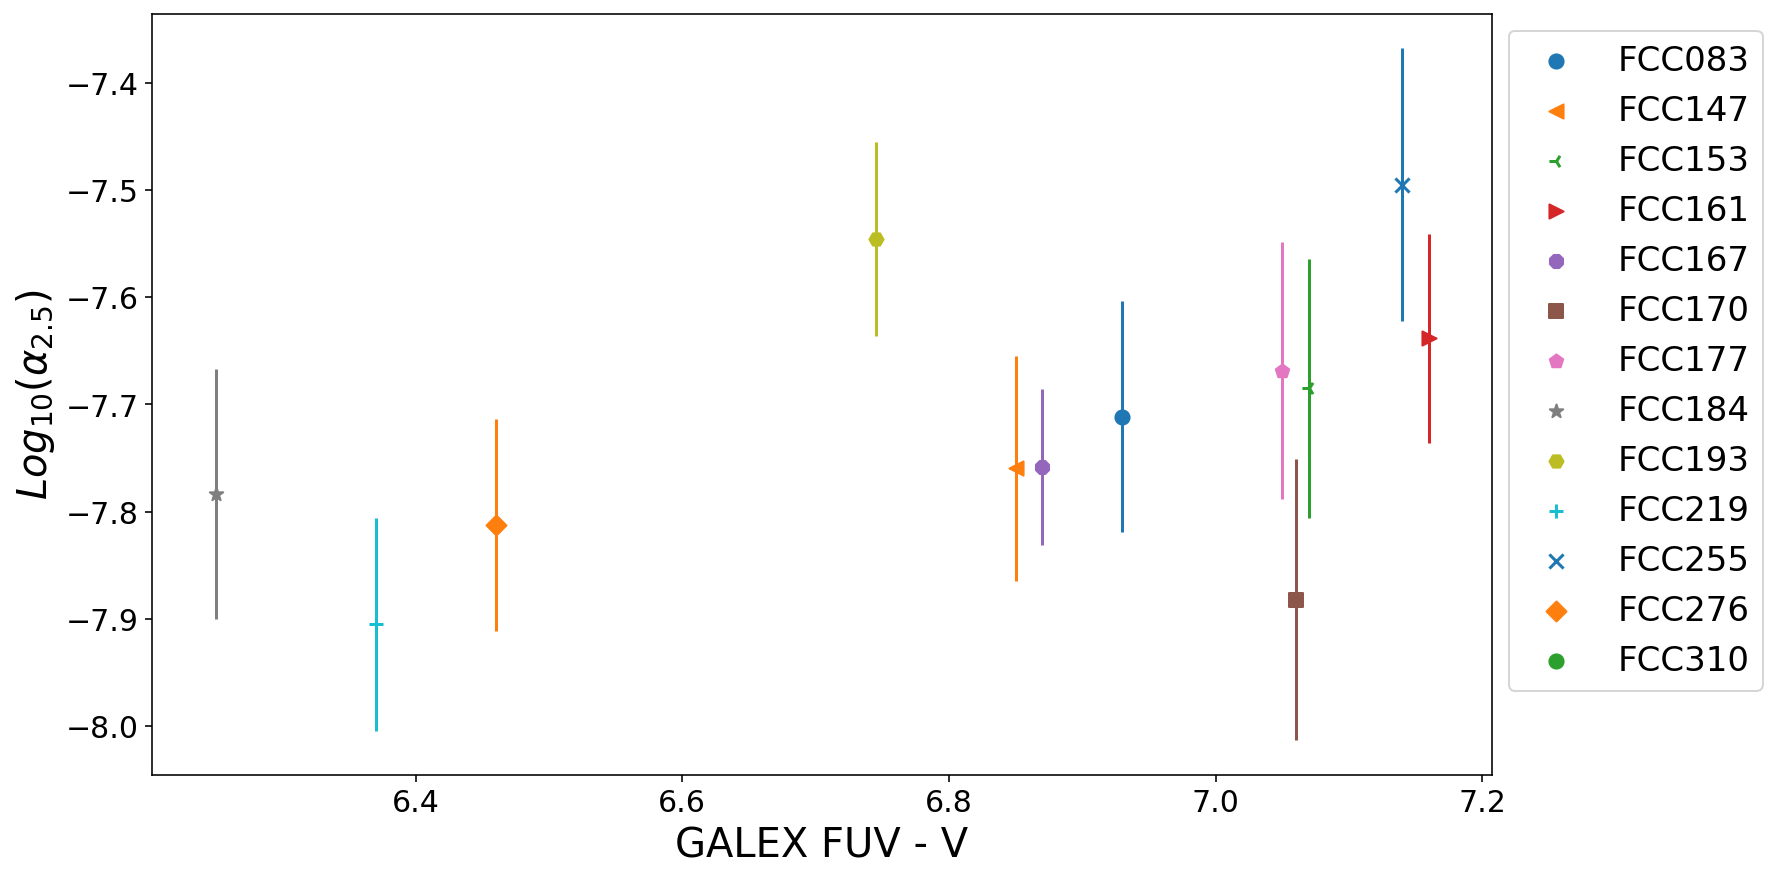

In [31]:
# lit Distance
plt.figure(figsize=(12,7))

# for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["GALEX_FUV"].loc[PN_filter]-gal_df["Rmag"].loc[PN_filter],gal_df["log alpha2.5"].loc[PN_filter]):
for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["GALEX FUV"].loc[PN_filter]-gal_df["Vmag"].loc[PN_filter],lit_gal_df["lit log alpha2.5"].loc[PN_filter]):
    plt.scatter(x_d,y_d, marker=gal_df.loc[gal, "marker"], s=50, label=gal_df.loc[gal, "Galaxy"])
    plt.errorbar(x=x_d, y=y_d, yerr=[[lit_gal_df["lit log alpha2.5 err lo"].iloc[gal]], [lit_gal_df["lit log alpha2.5 err lo"].iloc[gal]]], ls="None")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
f_size = 20
plt.legend(bbox_to_anchor=(1., 1.0), fontsize=f_size-3)
plt.xlabel("GALEX FUV - V", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
# plt.savefig("Plots/alpha_vs_GALEX_FUV_m_V.png", bbox_inches='tight')

Text(0, 0.5, '$Log_{10}(\\alpha_{2.5})$')

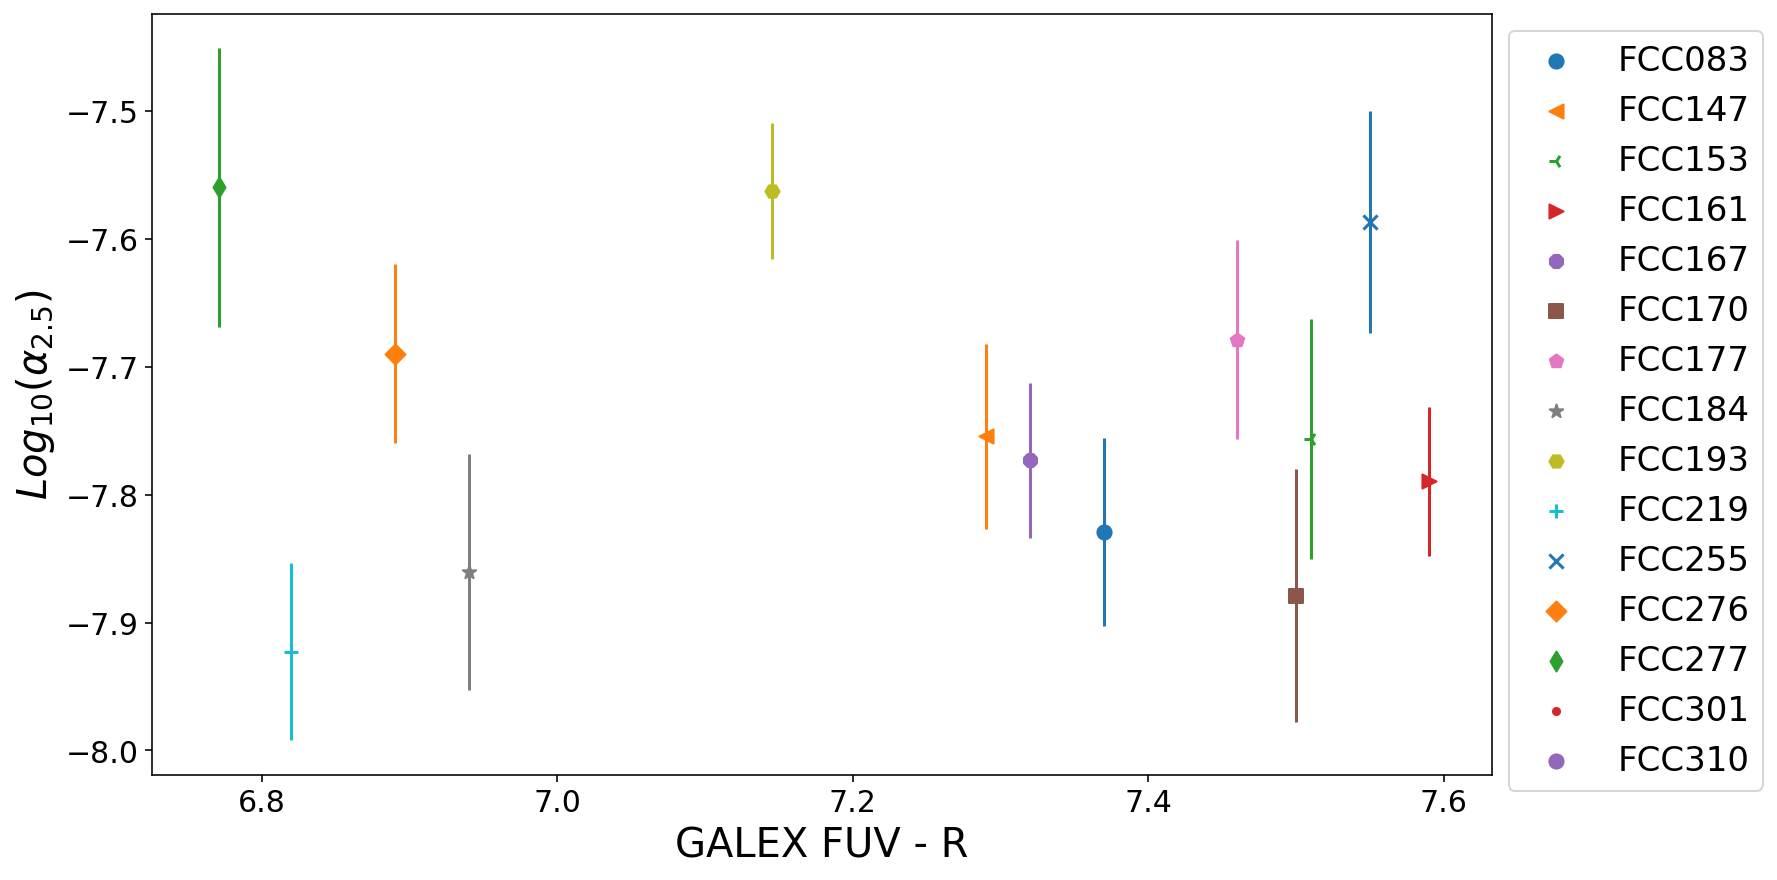

In [57]:
# PNLF distance
plt.figure(figsize=(12,7))

# for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["GALEX_FUV"].loc[PN_filter]-gal_df["Rmag"].loc[PN_filter],gal_df["log alpha2.5"].loc[PN_filter]):
for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["GALEX FUV"].loc[PN_filter]-gal_df["Rmag"].loc[PN_filter],gal_df["log alpha2.5"].loc[PN_filter]):
    plt.scatter(x_d,y_d, marker=gal_df.loc[gal, "marker"], s=50, label=gal_df.loc[gal, "Galaxy"])
    plt.errorbar(x=x_d, y=y_d, yerr=[[gal_df["log alpha2.5 err lo"].iloc[gal]], [gal_df["log alpha2.5 err lo"].iloc[gal]]], ls="None")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
f_size = 20
plt.legend(bbox_to_anchor=(1., 1.0), fontsize=f_size-3)
plt.xlabel("GALEX FUV - R", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
# plt.savefig("Plots/alpha_vs_GALEX_FUV_m_lit_R.png", bbox_inches='tight')

Text(0, 0.5, '$Log_{10}(\\alpha_{2.5})$')

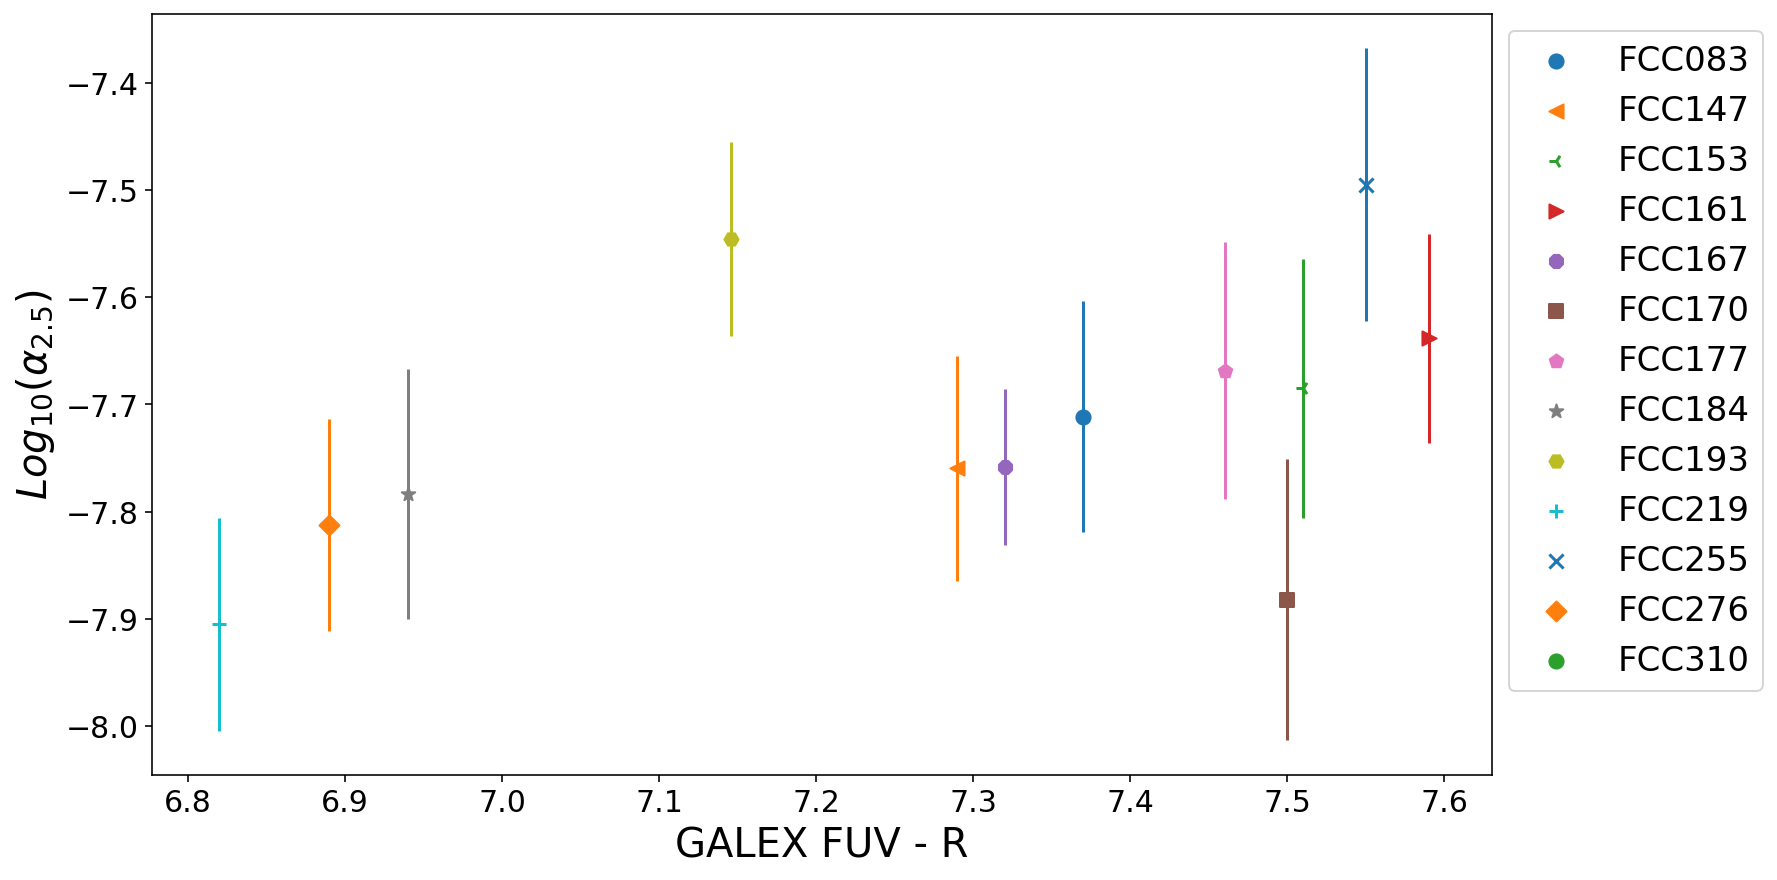

In [33]:
# lit distance
plt.figure(figsize=(12,7))

# for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["GALEX_FUV"].loc[PN_filter]-gal_df["Rmag"].loc[PN_filter],gal_df["log alpha2.5"].loc[PN_filter]):
for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["GALEX FUV"].loc[PN_filter]-gal_df["Rmag"].loc[PN_filter],lit_gal_df["lit log alpha2.5"].loc[PN_filter]):
    plt.scatter(x_d,y_d, marker=gal_df.loc[gal, "marker"], s=50, label=gal_df.loc[gal, "Galaxy"])
    plt.errorbar(x=x_d, y=y_d, yerr=[[lit_gal_df["lit log alpha2.5 err lo"].iloc[gal]], [lit_gal_df["lit log alpha2.5 err lo"].iloc[gal]]], ls="None")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
f_size = 20
plt.legend(bbox_to_anchor=(1., 1.0), fontsize=f_size-3)
plt.xlabel("GALEX FUV - R", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
# plt.savefig("Plots/alpha_vs_GALEX_FUV_m_lit_R.png", bbox_inches='tight')

In [110]:
sp.stats.spearmanr(a = FUV_M_NUV[:-1], b=gal_df["log alpha2.5"].loc[PN_filter][:-1])

SpearmanrResult(correlation=0.6643356643356644, pvalue=0.018452718028445437)

Text(0, 0.5, '$Log_{10}(\\alpha_{2.5})$')

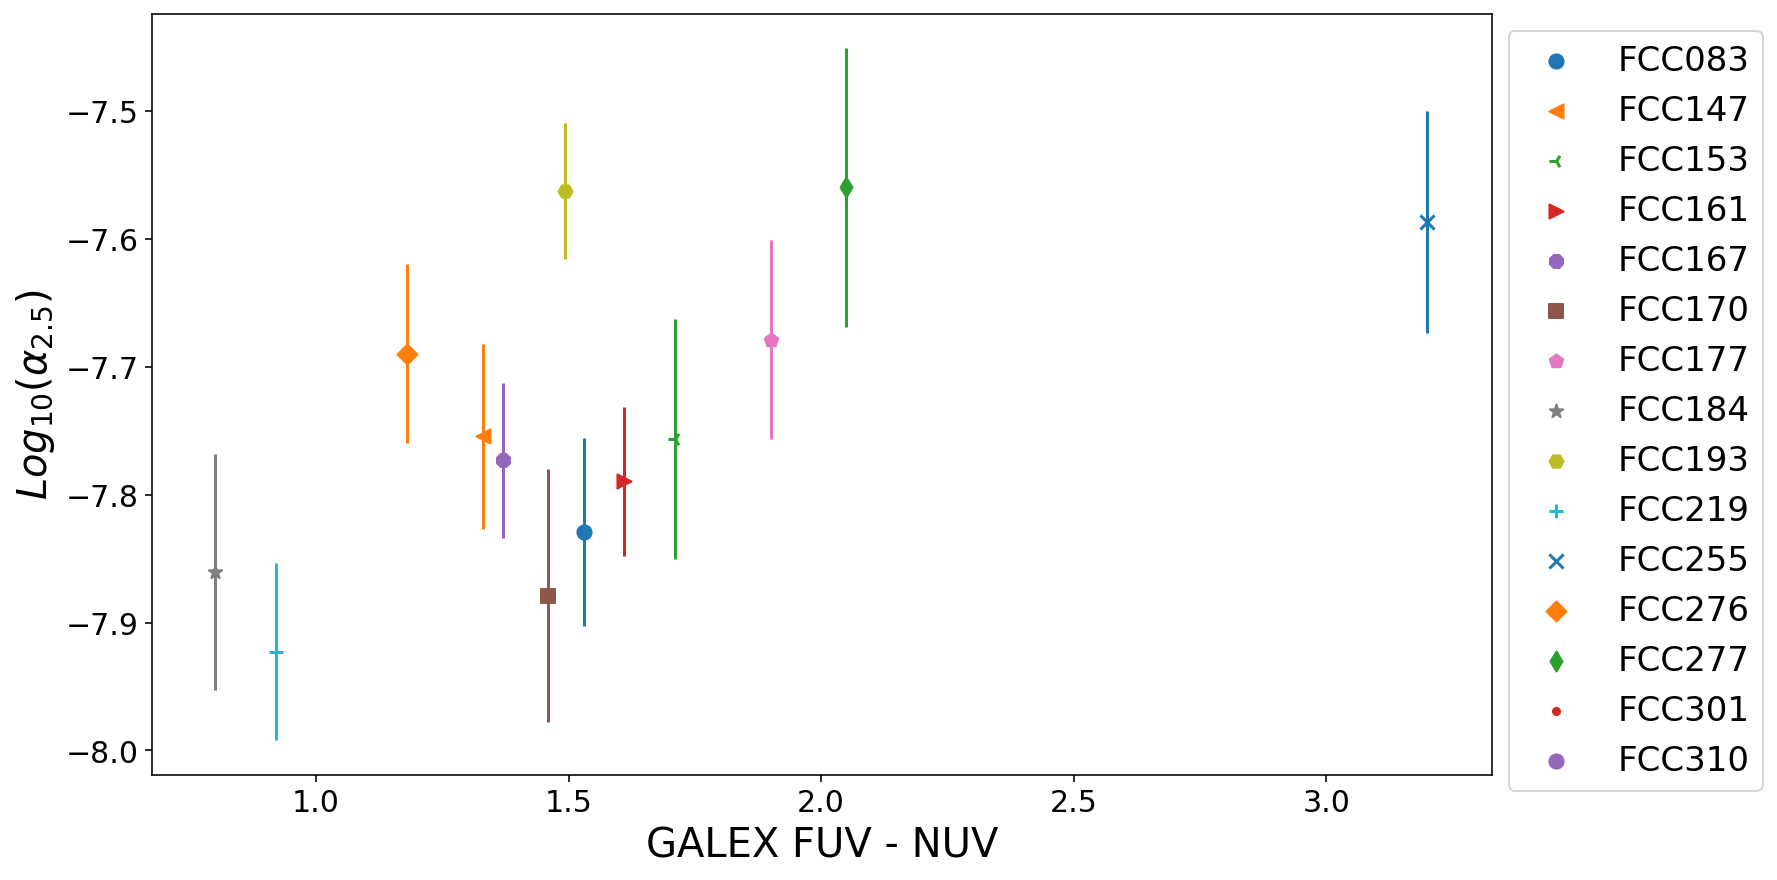

In [58]:
# PNLF distance
plt.figure(figsize=(12,7))

# for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["GALEX_FUV"].loc[PN_filter]-gal_df["Rmag"].loc[PN_filter],gal_df["log alpha2.5"].loc[PN_filter]):
for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["GALEX FUV"].loc[PN_filter]-gal_df["GALEX NUV"].loc[PN_filter],gal_df["log alpha2.5"].loc[PN_filter]):
    plt.scatter(x_d,y_d, marker=gal_df.loc[gal, "marker"], s=50, label=gal_df.loc[gal, "Galaxy"])
    plt.errorbar(x=x_d, y=y_d, yerr=[[gal_df["log alpha2.5 err lo"].iloc[gal]], [gal_df["log alpha2.5 err lo"].iloc[gal]]], ls="None")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
f_size = 20
plt.legend(bbox_to_anchor=(1., 1.0), fontsize=f_size-3)
plt.xlabel("GALEX FUV - NUV", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
# plt.savefig("Plots/alpha_vs_GALEX_FUV_m_NUV.png", bbox_inches='tight')

Text(0, 0.5, '$Log_{10}(\\alpha_{2.5})$')

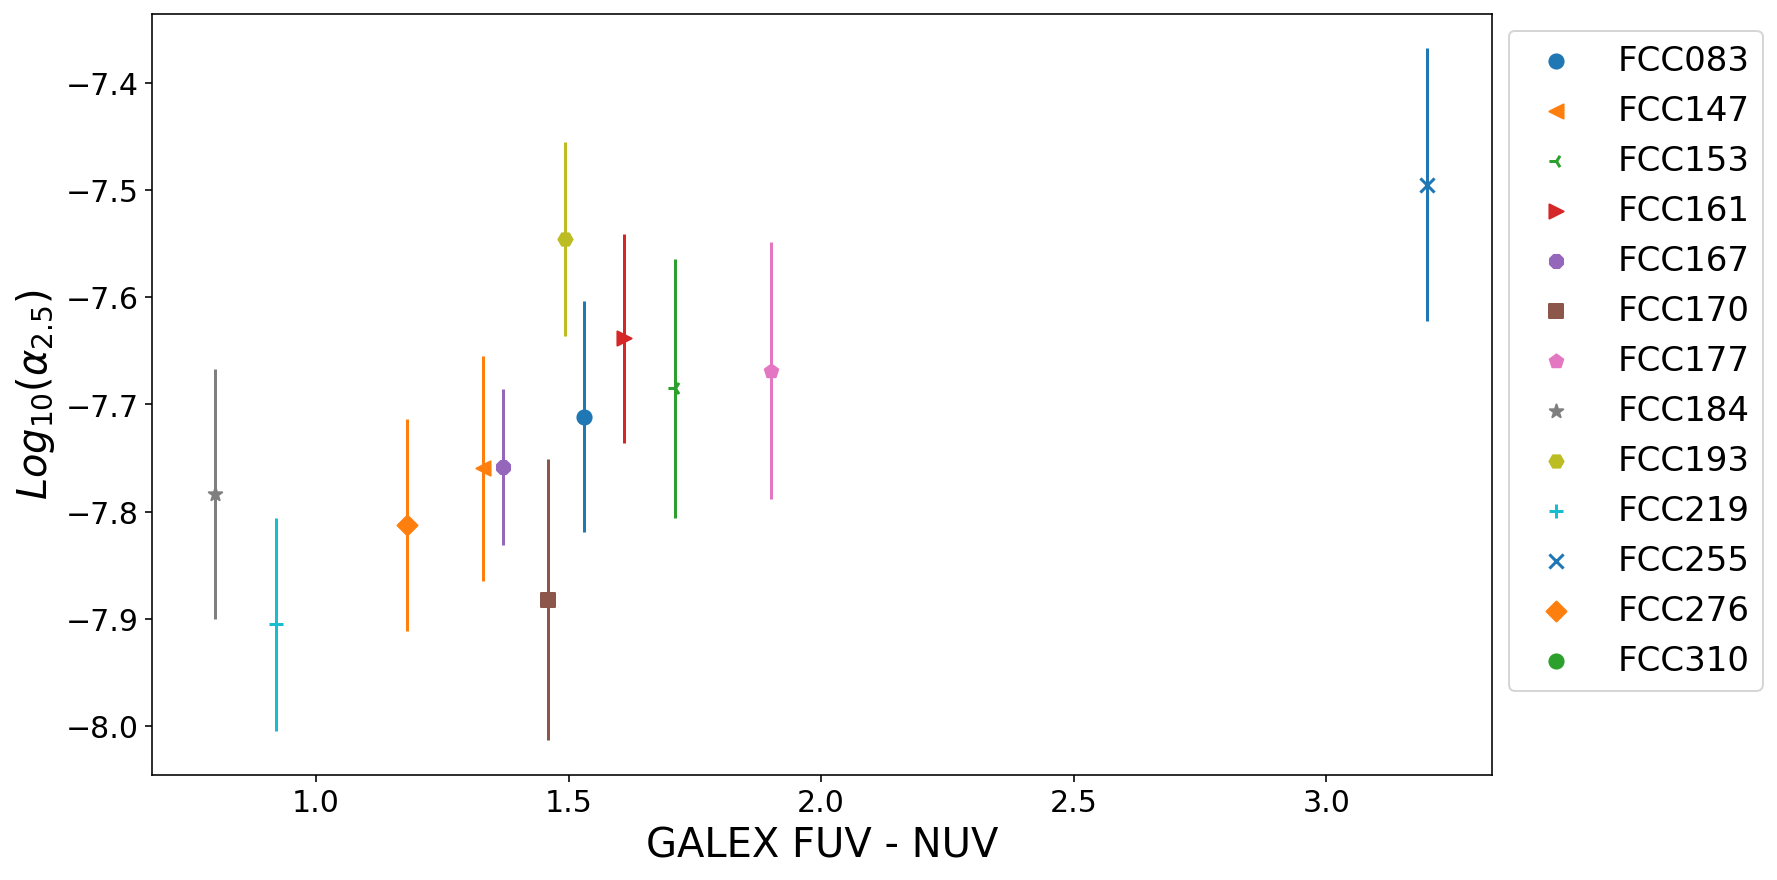

In [35]:
# lit distance
plt.figure(figsize=(12,7))

# for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["GALEX_FUV"].loc[PN_filter]-gal_df["Rmag"].loc[PN_filter],gal_df["log alpha2.5"].loc[PN_filter]):
for gal, x_d, y_d in zip(gal_df["Galaxy"].loc[PN_filter].index,gal_df["GALEX FUV"].loc[PN_filter]-gal_df["GALEX NUV"].loc[PN_filter],lit_gal_df["lit log alpha2.5"].loc[PN_filter]):
    plt.scatter(x_d,y_d, marker=gal_df.loc[gal, "marker"], s=50, label=gal_df.loc[gal, "Galaxy"])
    plt.errorbar(x=x_d, y=y_d, yerr=[[lit_gal_df["lit log alpha2.5 err lo"].iloc[gal]], [lit_gal_df["lit log alpha2.5 err lo"].iloc[gal]]], ls="None")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
f_size = 20
plt.legend(bbox_to_anchor=(1., 1.0), fontsize=f_size-3)
plt.xlabel("GALEX FUV - NUV", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
# plt.savefig("Plots/alpha_vs_GALEX_FUV_m_NUV.png", bbox_inches='tight')

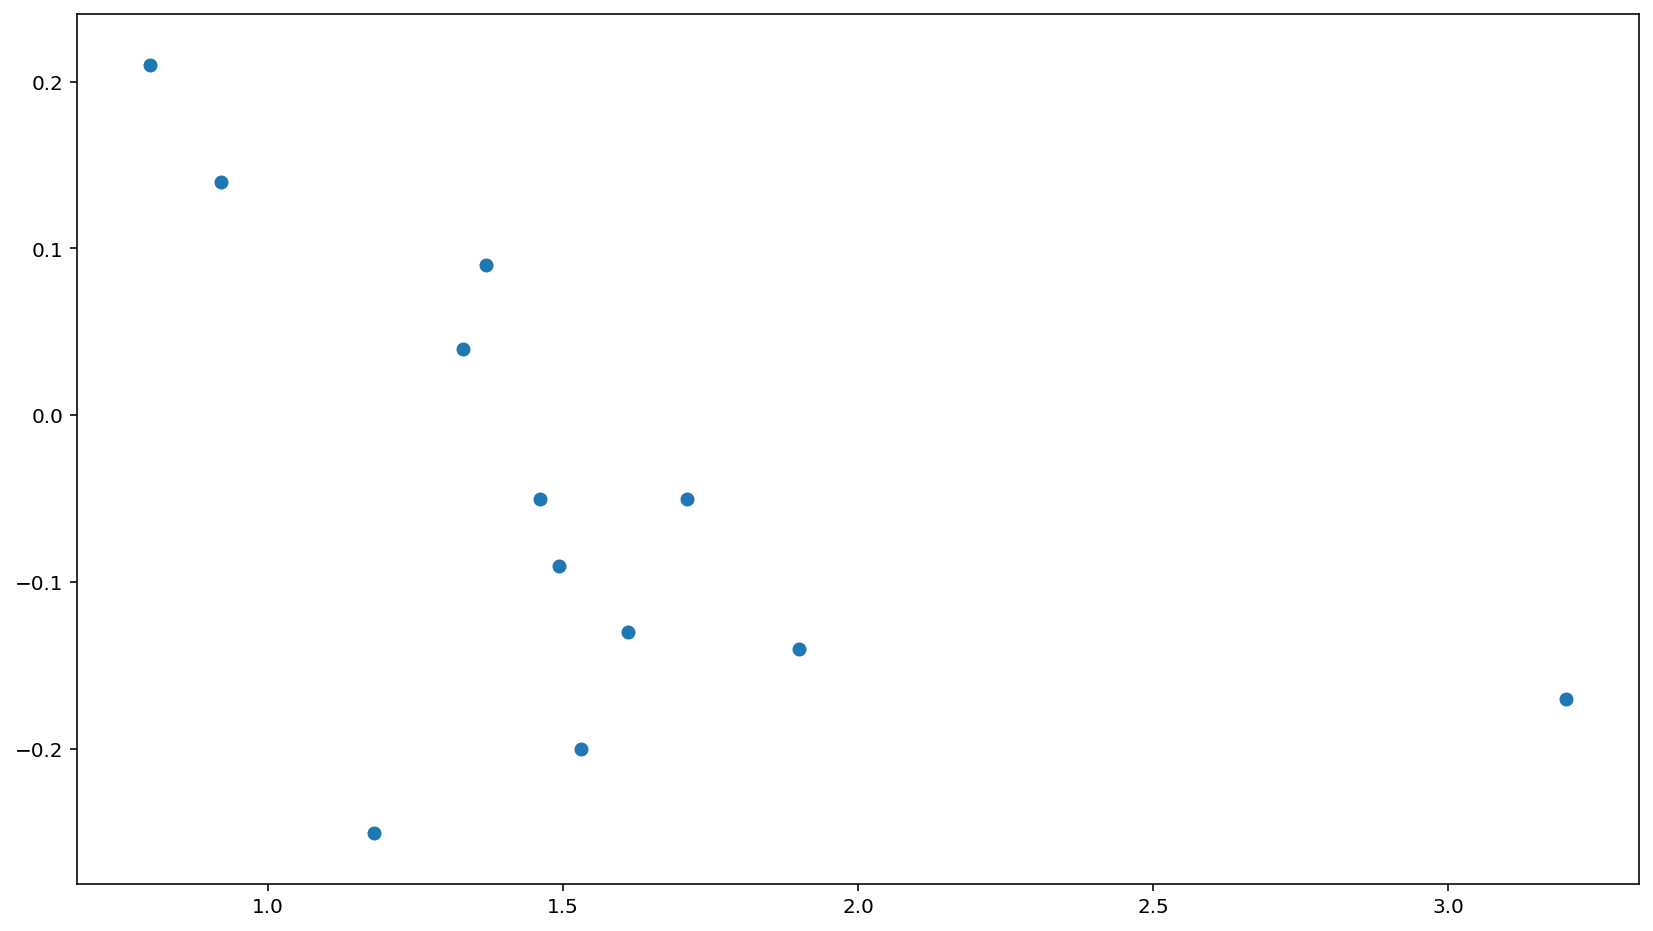

In [36]:
# FUV -NUV vs FUV -R
plt.figure(figsize=(14,8))
plt.scatter(gal_df["GALEX FUV"].loc[PN_filter]-gal_df["GALEX NUV"].loc[PN_filter], gal_df["M/H"].loc[PN_filter])

In [37]:
FUV_M_NUV = gal_df["GALEX FUV"].loc[PN_filter].values-gal_df["GALEX NUV"].loc[PN_filter].values
sp.stats.spearmanr(a=FUV_M_NUV[:-1], b=gal_df["M/H"].loc[PN_filter][:-1])

SpearmanrResult(correlation=-0.5674264393540605, pvalue=0.05432400567596983)

(1.0, 2)

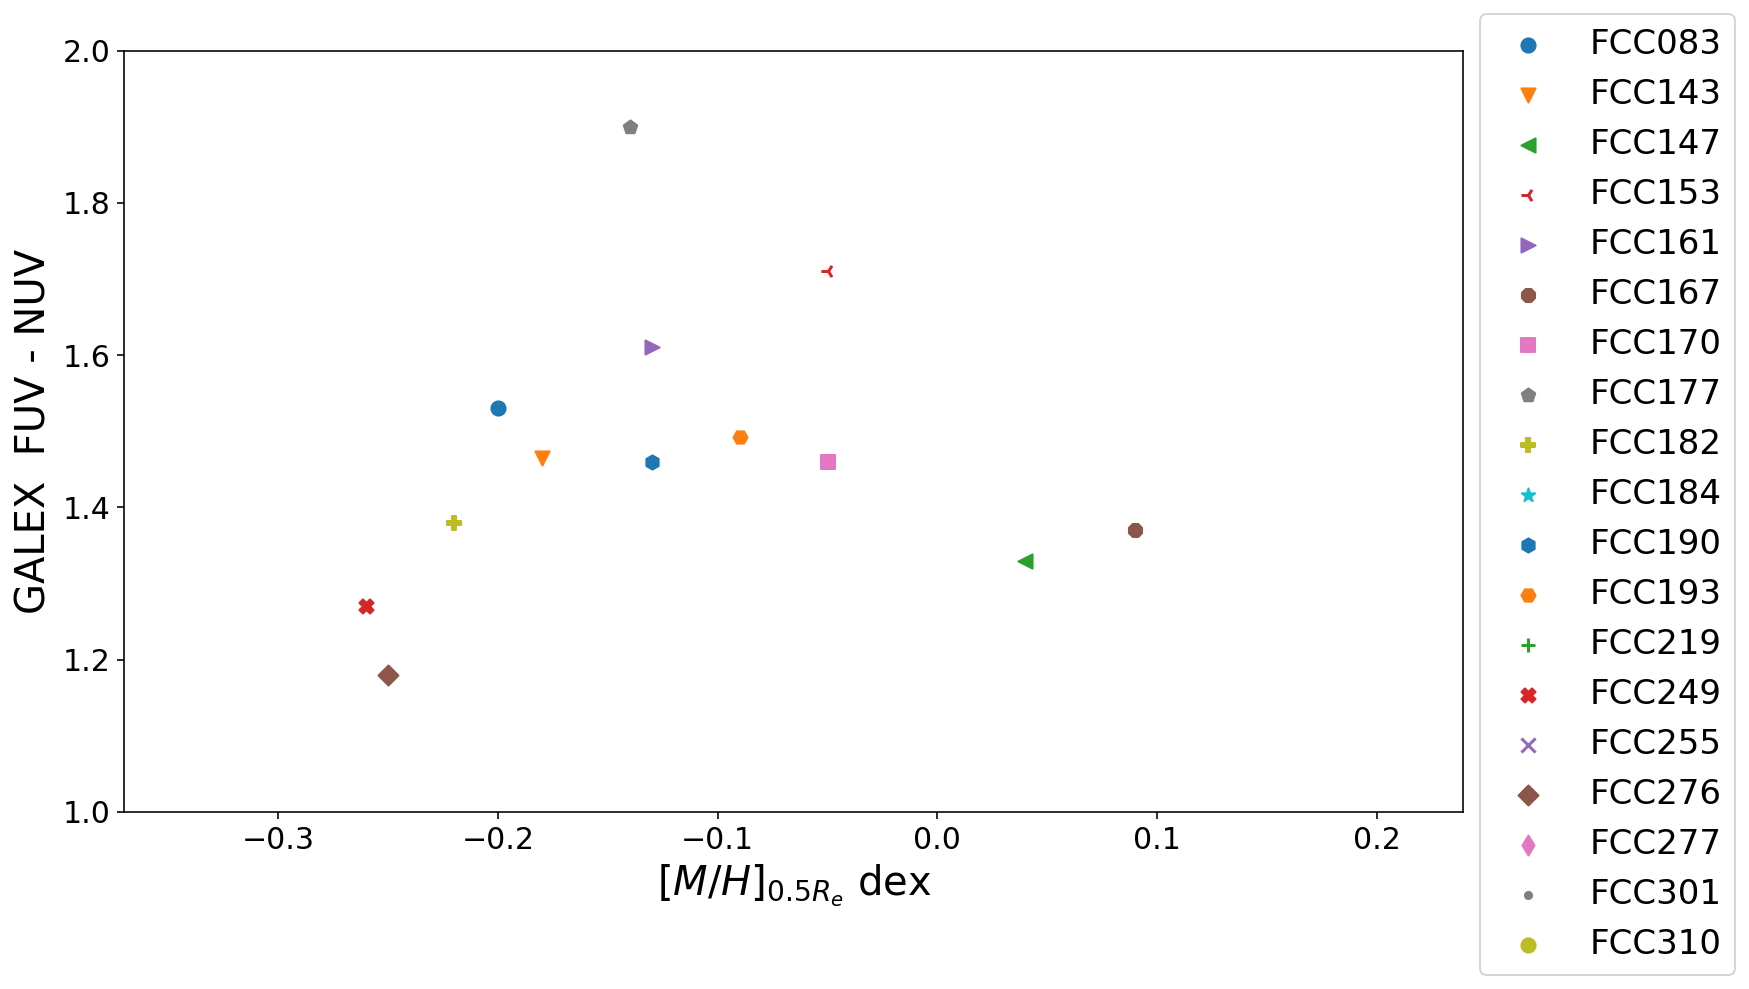

In [59]:
plt.figure(figsize=(12,7))

for gal, x_d, y_d in zip(gal_df["Galaxy"].index,gal_df["M/H"],gal_df["GALEX FUV"]-gal_df["GALEX NUV"]): #GALEX NUV
    plt.scatter(x_d,y_d, marker=gal_df.loc[gal, "marker"], s=50, label=gal_df.loc[gal, "Galaxy"])
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
f_size = 20
ax = plt.gca()

plt.legend(bbox_to_anchor=(1., 1.07), fontsize=f_size-3)
plt.ylabel("GALEX  FUV - NUV", fontsize=f_size)
plt.xlabel(r"$[M/H]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.ylim( 1.,2)
# plt.savefig("Plots/MH_vs_GALEX_UV.png", bbox_inches='tight')

In [ ]:
plt.figure(figsize=(8,5))
for i, P_N, p_N in zip(gal_df["Galaxy"].index,gal_df["FUV"]-gal_df["lit Rmag"], gal_df["alpha2.5"]):
    plt.scatter(P_N, p_N, marker=gal_df.loc[i, "marker"], c="b",s=35, label=gal_df.loc[i, "Galaxy"])
for i, P_N, p_N in zip(gal_df["Galaxy"].index,gal_df["FUV-R"], gal_df["alpha2.5"]):
    plt.scatter(P_N, p_N, marker=gal_df.loc[i, "marker"], c="k",s=35, label=gal_df.loc[i, "Galaxy"])
# plt.legend()
# plt.xlim(0.08, 0.325)
# plt.axhline(0.5e10)
# plt.axhline(20)
# plt.axvline(50)

## Buzzoni data retrieval and comprison

In [40]:
##### Buzzoni data
list_of_B_g = ["205", "221", "224", "1316", "1344", "1399", "3031", "3115",
                 "3377", "3379", "3384", "4374", "4382", "4406", "4477", "4486",
                 "4594", "4649", "4697", "5128"]

Buzzoni_UV_m_V = [1.19,4.50, 3.51, 5.0, np.nan, 2.05, np.nan, 3.43, np.nan, 3.86, 3.9, 3.55, 4.22, 3.72, 3.42, 2.04, np.nan, 2.24, 3.41, np.nan]
Buzzoni_log_a  = np.array([-6.88, -6.77, -6.94, -7.5, -6.75, -7.30, -6.8, -6.59, -6.43, -6.77, -6.42, -6.77, -6.7, -6.89, -7.16, -7.10, -6.66, -7.22, -6.82, -6.3])
Buzzoni_log_sig = [1.61, 1.9, 2.27, 2.38, 2.22, 2.52, 2.23, 2.45, 2.16, 2.33, 2.20, 2.48, 2.24, 2.42, 2.49, 2.60, 2.41, 2.56, 2.25, 2.14]

Buzz_df = pd.DataFrame(columns=("Galaxy", "alpha", "UV m V", "log sigma"))
Buzz_df["Galaxy"] = [f"NGC {i}" for i in list_of_B_g]
Buzz_df["alpha"] = Buzzoni_log_a
Buzz_df["UV m V"] = Buzzoni_UV_m_V
Buzz_df["log sigma"] = Buzzoni_log_sig



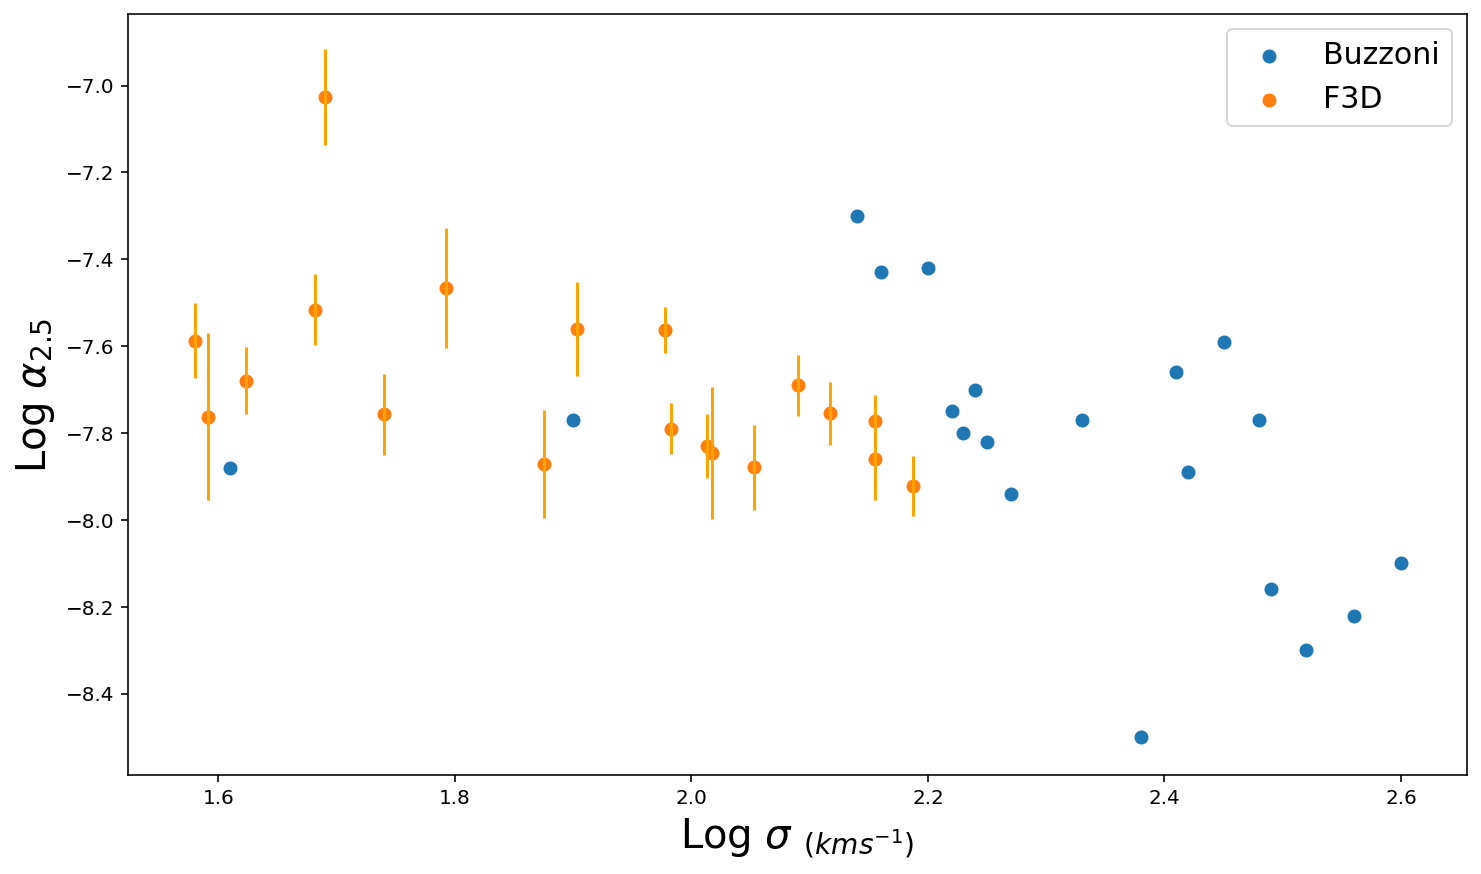

In [41]:
plt.figure(figsize=(12,7))
plt.scatter(Buzz_df["log sigma"], Buzz_df["alpha"]-1, label="Buzzoni")
plt.scatter(np.log10(gal_df["sigma"]), gal_df["log alpha2.5"], label="F3D")
plt.errorbar(x=np.log10(gal_df["sigma"]), y=gal_df["log alpha2.5"], yerr=[np.array(gal_df["log alpha2.5 err lo"].values), np.array(gal_df["log alpha2.5 err lo"].values)], xerr=None, ls="None", c="orange" )

plt.legend(fontsize=15)
plt.ylabel(r"Log $\alpha_{2.5}$", fontsize=20)
plt.xlabel(r"Log $\sigma \ _{(km s^{-1})}$", fontsize=20)
plt.savefig("Plots/alpha_vs_log_sigma_comparison.png")

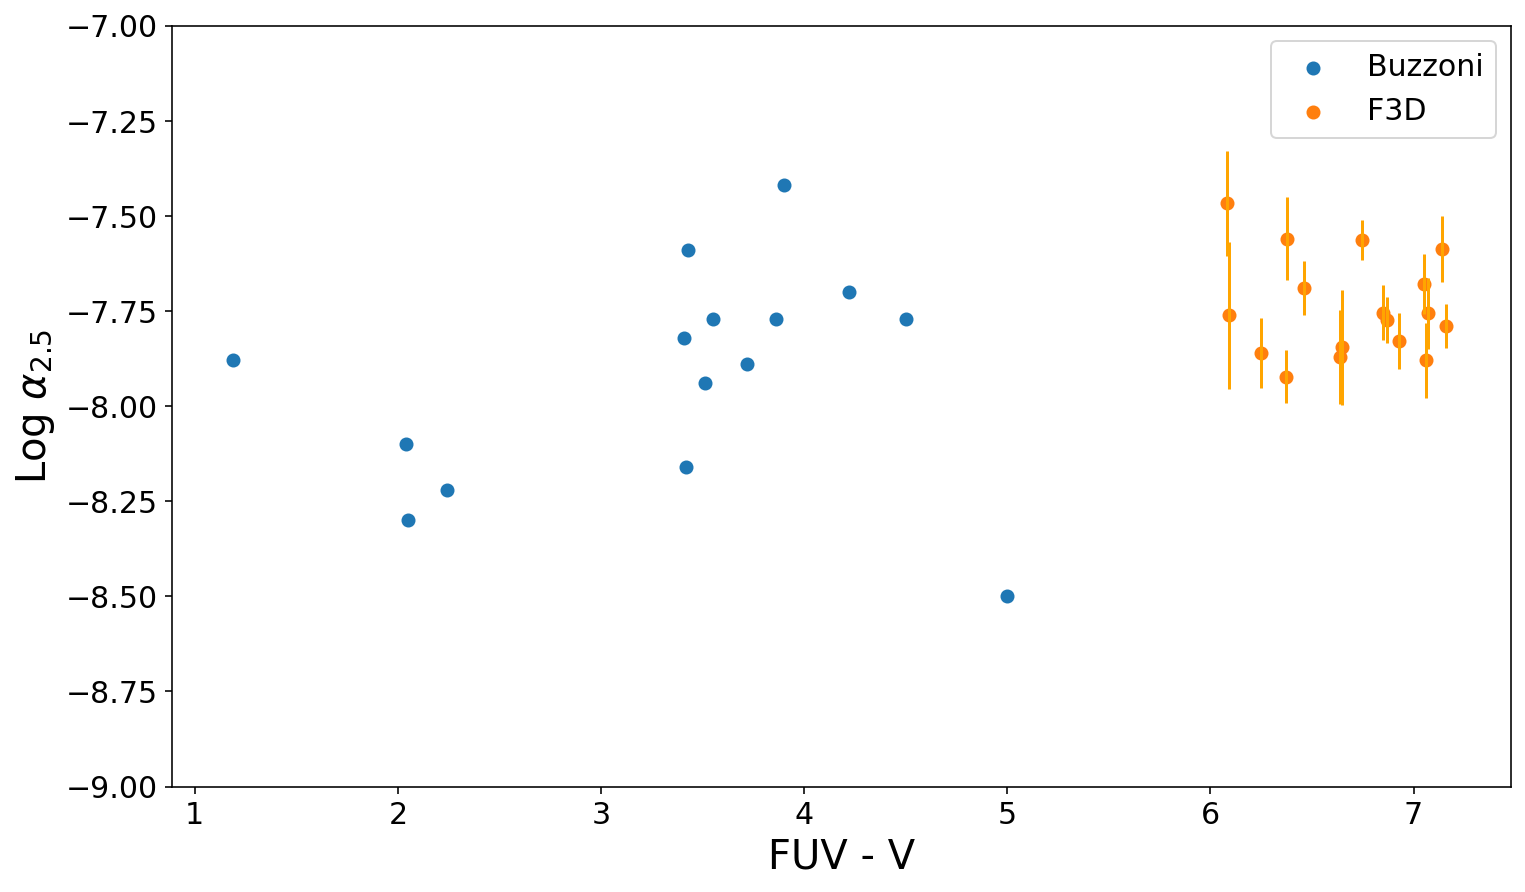

In [42]:
plt.figure(figsize=(12,7))
plt.scatter(Buzz_df["UV m V"], Buzz_df["alpha"]-1, label="Buzzoni")
plt.scatter(gal_df["GALEX FUV"]-gal_df["Vmag"], gal_df["log alpha2.5"], label="F3D")
plt.errorbar(x=gal_df["GALEX FUV"]-gal_df["Vmag"], y=gal_df["log alpha2.5"], yerr=[np.array(gal_df["log alpha2.5 err lo"].values), np.array(gal_df["log alpha2.5 err lo"].values)], xerr=None, ls="None", c="orange" )
plt.legend(fontsize=15)
plt.ylabel(r"Log $\alpha_{2.5}$", fontsize=20)
plt.xlabel("FUV - V", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-9,-7)
plt.savefig("Plots/alpha_vs_FUV_m_V_comparison.png")

In [3]:
def linear_reg(x, y, n_sample=500, n_chains=5,n_cores=1):
    data = dict(x=x, y=y)

    with pm.Model() as model:
        # specify glm and pass in data. The resulting linear model, its likelihood and
        # and all its parameters are automatically added to our model.
        pm.glm.GLM.from_formula('y ~ x', data)
        trace = pm.sample(n_sample, chains=n_chains, cores=n_cores)
    
    x_axis = np.linspace(x.min(), x.max(), len(x))
    
    slope_data = trace.get_values("x")
    int_data = trace.get_values("Intercept")

    y_model_glm = [m*x_axis + b for m,b in zip(slope_data, int_data)]
    y_model = np.median(y_model_glm, axis=0)
    perc_16 = np.percentile(y_model_glm, 16, axis=0)
    perc_84 = np.percentile(y_model_glm, 84, axis=0)
    
    
    return [y_model, perc_16, perc_84, x_axis]
        

In [4]:
def boot_func(x, y, boot_num=500):
    boot_zip = np.array([[i,j] for i,j in zip(x, y)])
    
    with NumpyRNGContext(1):
        boot_result = bootstrap(boot_zip, boot_num)
        
    slope = np.ones(num)
    intercept = np.ones(num)
    for n in np.arange(num):
        slope[n], intercept[n], r_value, p_value, std_err_list = stats.linregress(boot_result[n,:,0],boot_result[n,:,1]) 
        
    
    x_axis = np.linspace(x.min(), x.max(), num=len(x))
    
    y_model = [np.array(m*x_axis + b, dtype=float) for m,b in zip(slope, intercept)]
    med_y = np.array(np.nanmedian(y_model,axis=0), dtype=float)
    y_16 = np.array(np.nanpercentile(y_model, 16,axis=0) , dtype=float)
    y_84 = np.array(np.nanpercentile(y_model, 84,axis=0) , dtype=float)
    
    #best_slope, best_int, *stuff = stats.linregress([x_axis[0], x_axis[-1]],[np.nanmedian(med_y,0)[0], np.nanmedian(med_y,0)[-1]])
    
    return med_y, y_16, y_84, x_axis
    
# b_med_y, y_16, y_84, b_x_axis = boot_func(gal_df[item].loc[PN_filter], gal_df["alpha2.5"].loc[PN_filter], 1000)
# plt.plot(b_x_axis, b_med_y, label="bootstrap fit", c="r", alpha=0.7)
# plt.fill_between(b_x_axis, y_16, y_84, alpha=0.3, label="bootstrap confidence interval", color="r")

m = -0.43109107911213695, b = 0.6235628040562768


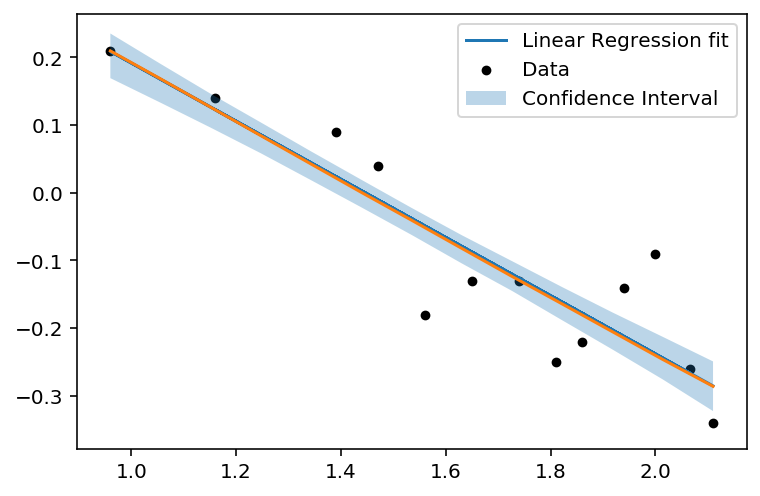

In [95]:

boot_1 = gal_df["FUV-NUV"].loc[pd.notnull(gal_df["FUV-NUV"])]
boot_2 = gal_df["M/H"].loc[pd.notnull(gal_df["FUV-NUV"])]
boot_arr = np.array([[i,j] for i,j in zip(boot_1, boot_2)])

num = 1000

with NumpyRNGContext(1):
    bootresult_1 = bootstrap(boot_arr, num)
#     

slope = np.ones(num)
intercept = np.ones(num)

for n in np.arange(num):
    slope[n], intercept[n], r_value, p_value, std_err_list = stats.linregress(bootresult_1[n,:,0],bootresult_1[n,:,1])
    
# plot data points
plt.scatter(boot_1, boot_2, c="k", label="Data", s=15)

# nan median of slope and intercept
med_slope = np.nanmedian(slope)
med_int = np.nanmedian(intercept)

# plt.ylabel("M/H")
y = med_slope*boot_1 + med_int
plt.plot(boot_1, y, label="Linear Regression fit")
# generate x array, from min to max of x data,
x_axis = np.linspace(boot_1.min(), boot_1.max(), num=len(boot_1))

# generate y model, and get median, 16th and 84th percentiles
y_model = [np.array(m*x_axis + b, dtype=float) for m,b in zip(slope, intercept)]
med_y = np.array([np.nanmedian(y_model,axis=0) for m in y_model], dtype=float)
y_16 = np.array(np.nanpercentile(y_model, 16,axis=0) , dtype=float)
y_84 = np.array(np.nanpercentile(y_model, 84,axis=0) , dtype=float)

plt.plot(x_axis, np.nanmedian(med_y,0))
plt.fill_between(np.array(x_axis, dtype=float), y_16, y_84, alpha=0.3, label="Confidence Interval")
plt.legend()

best_slope, best_int, *stuff = stats.linregress([x_axis[0], x_axis[-1]],[np.nanmedian(med_y,0)[0], np.nanmedian(med_y,0)[-1]])
print(f"m = {best_slope}, b = {best_int}")

In [ ]:
x = gal_df["FUV-NUV"].loc[pd.notnull(gal_df["FUV-NUV"])].values
y = gal_df["M/H"].loc[pd.notnull(gal_df["FUV-NUV"])].values

gal_data = dict(x=x, y=y)

with pm.Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula('y ~ x', gal_data)
    trace = pm.sample(5000, chains=10, cores=2, tune=1000) 
    
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();

plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
pm.plot_posterior_predictive_glm(trace, samples=100,eval=x,
                              label='posterior predictive regression lines', alpha=0.2)
plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');



plt.fill_between(x_axis, perc_16, perc_18, alpha=0.4)

print(np.median(trace.get_values("Intercept")))
print(np.median(trace.get_values("x")))

0.6150676778443911
-0.42654620781873565


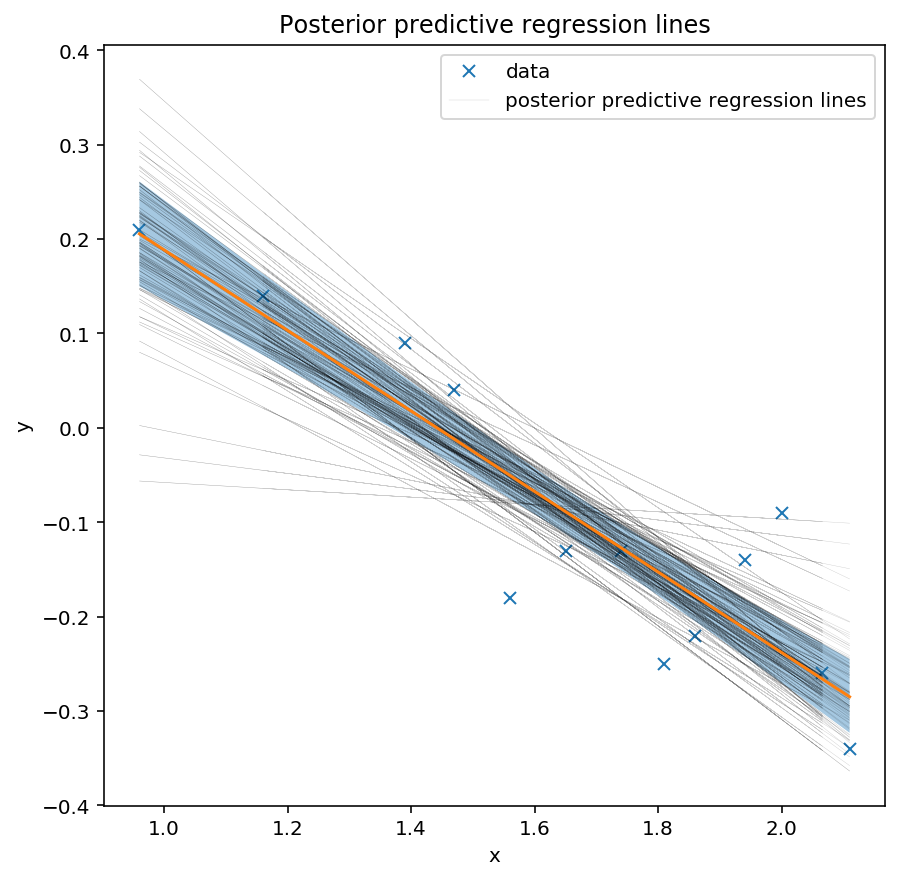

In [123]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
pm.plot_posterior_predictive_glm(trace, samples=100,eval=x,
                              label='posterior predictive regression lines', alpha=0.2)
plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

x_axis = np.linspace(x.min(), x.max(), len(x))

plt.plot(x_axis, np.median(trace.get_values("x"))*x_axis+np.median(trace.get_values("Intercept")))
slope_data = trace.get_values("x")
int_data = trace.get_values("Intercept")

y_model_glm = [m*x_axis + b for m,b in zip(slope_data, int_data)]
perc_16 = np.percentile(y_model_glm, 16, axis=0)
perc_84 = np.percentile(y_model_glm, 84, axis=0)



plt.fill_between(x_axis, perc_16, perc_84, alpha=0.4)

print(np.median(trace.get_values("Intercept")))
print(np.median(trace.get_values("x")))

# Plot out the galaxy data

In [21]:
things_to_comp_a = ["FUV-R", "FUV-V", "M/H", "FUV-NUV"]
things_to_comp_m = ["M/H", "B-V"]

PN_filter  = (gal_df["PNe N"]>20) & pd.notnull(gal_df["alpha2.5"])
# PN_filter  = pd.notnull(gal_df["alpha2.5"])
FUV_filter = pd.notnull(gal_df["FUV-NUV"])

lin_reg_a = []
lin_reg_m = []

for n,item in enumerate(things_to_comp_a):
    lin_reg_a.append(linear_reg(gal_df[item].loc[PN_filter], gal_df["alpha2.5"].loc[PN_filter], 1500,5,3))
    
for n,item in enumerate(things_to_comp_m):
    lin_reg_m.append(linear_reg(gal_df[item].loc[FUV_filter], gal_df["FUV-NUV"].loc[FUV_filter], 1500,5,3))



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 3 jobs)
NUTS: [sd, x, Intercept]
Sampling 5 chains: 100%|██████████| 10000/10000 [00:30<00:00, 329.06draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5899217658138559, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6559621345544686, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for s

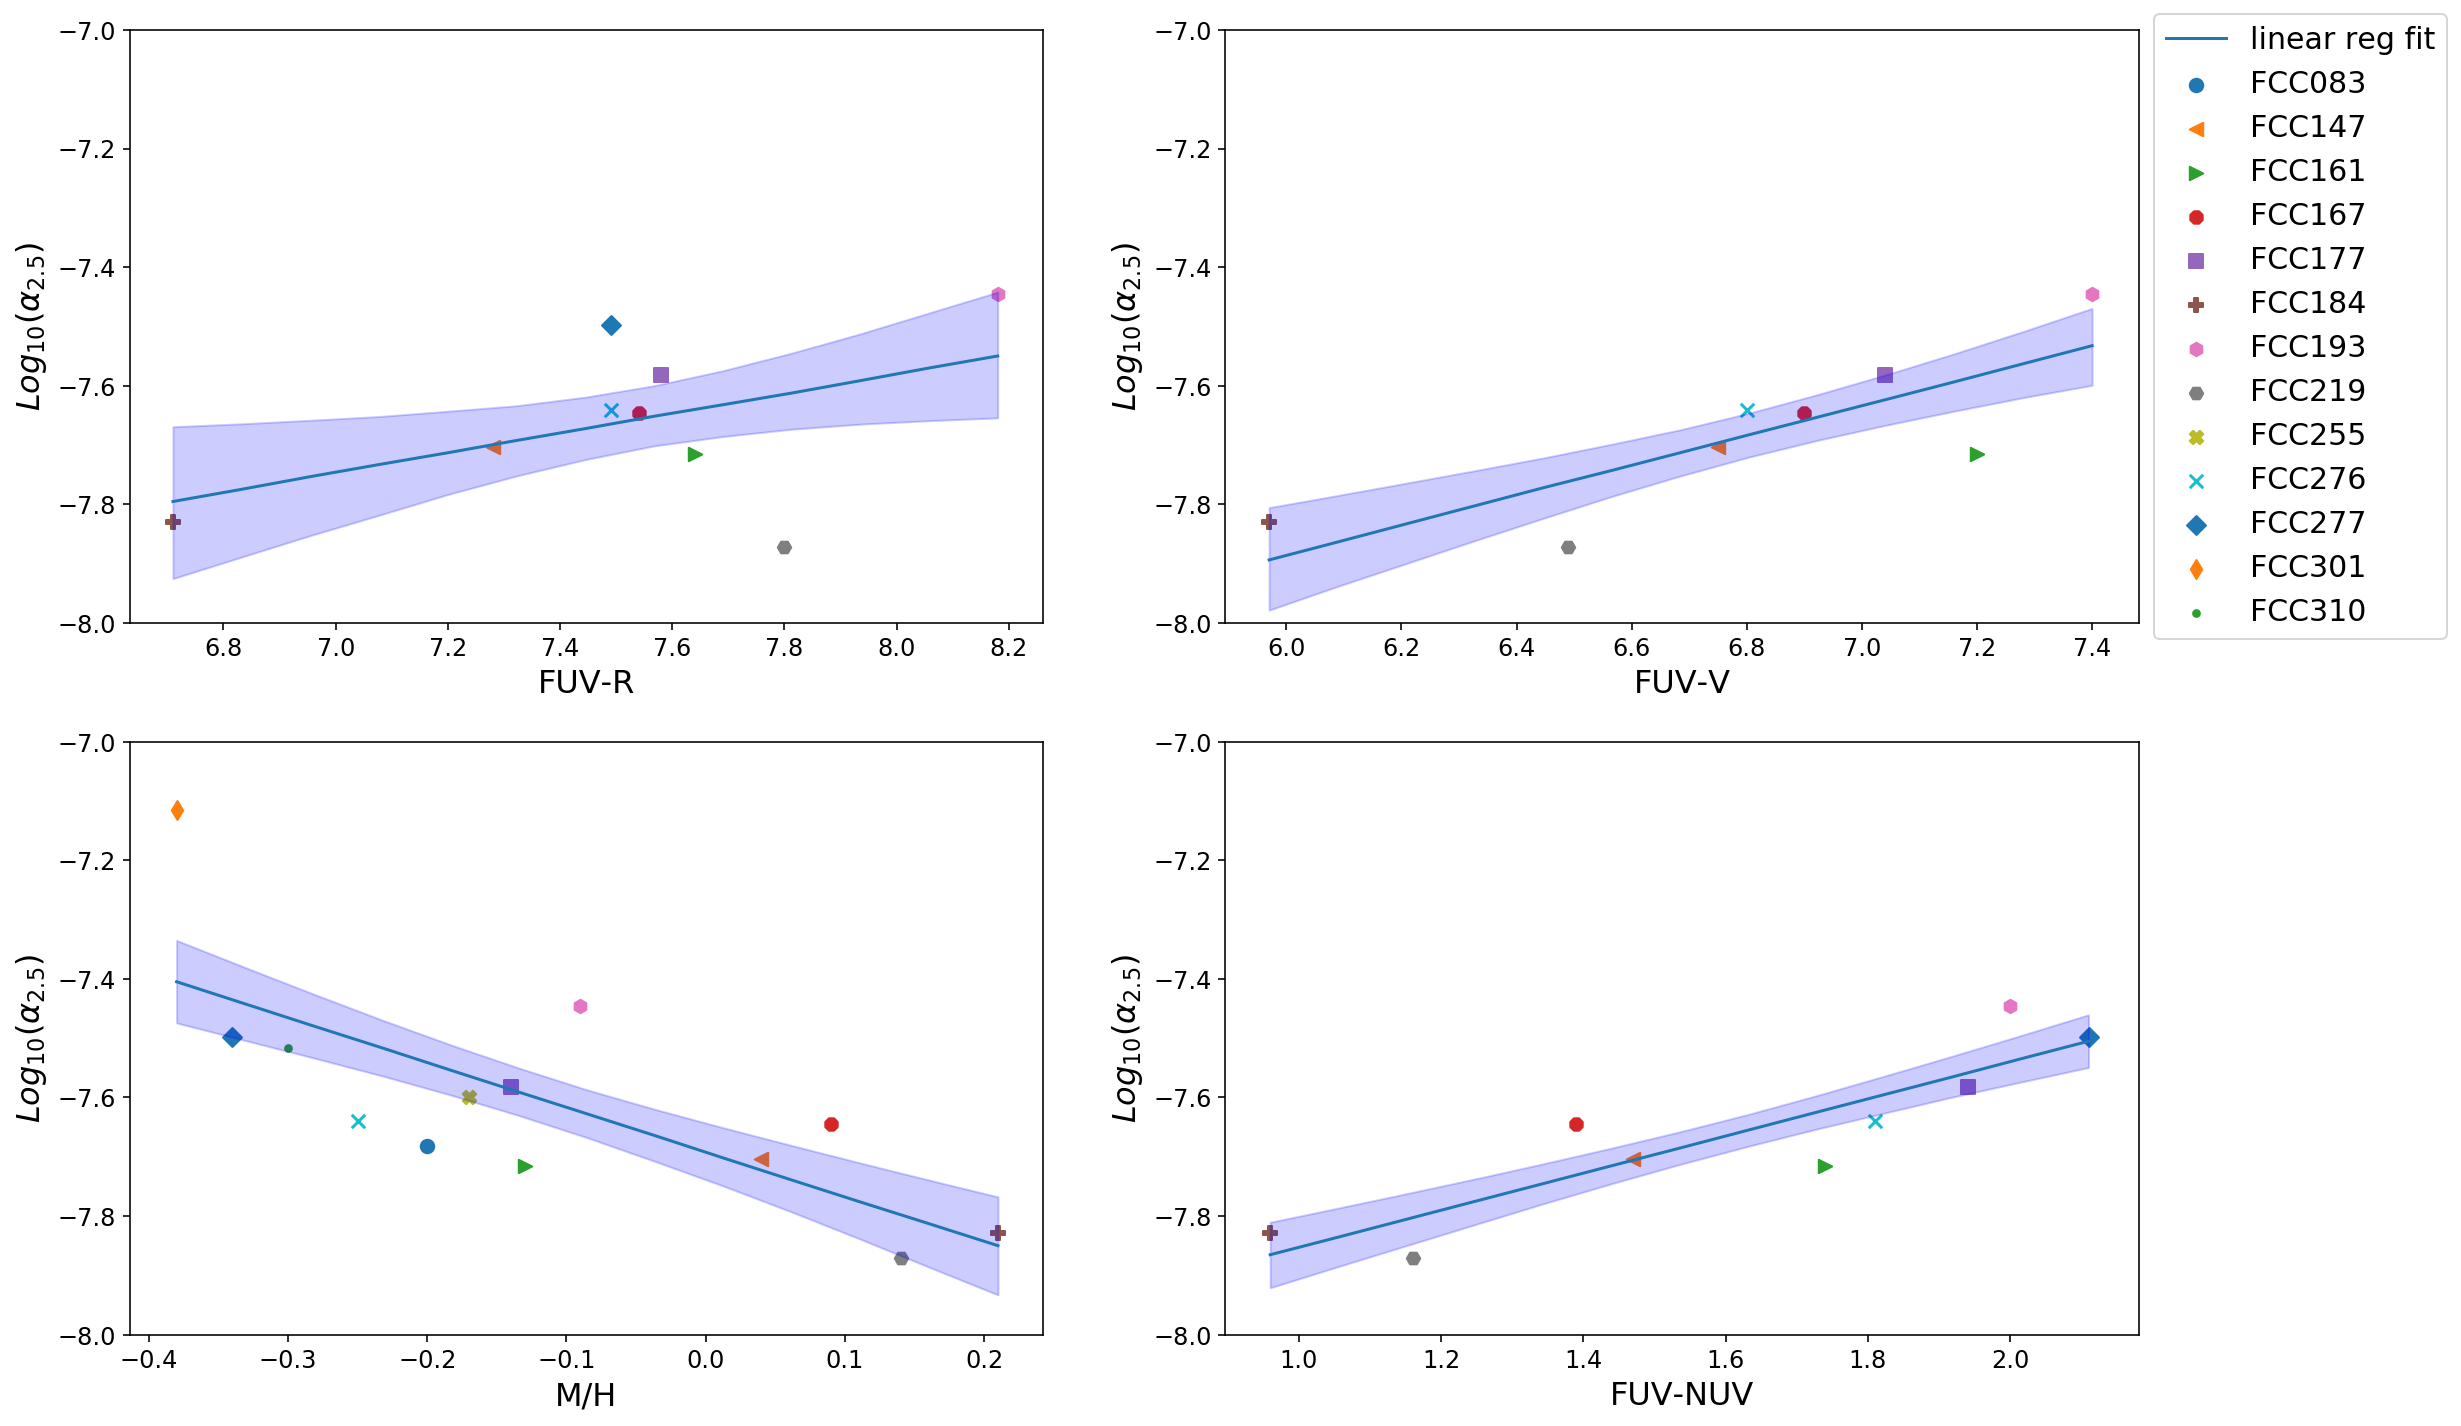

In [113]:
# Plotting
font_s  = 16
label_s = 12
plt.figure(figsize=(18,12))

for n,item in enumerate(things_to_comp_a):
    ax = plt.subplot(2,2,n+1)
    for i, x_dat, y_dat in zip(gal_df[item].loc[PN_filter].index,gal_df[item].loc[PN_filter], gal_df["alpha2.5"].loc[PN_filter]):
        plt.scatter(x_dat, y_dat, marker=gal_df.loc[i, "marker"], s=45, label=gal_df.loc[i, "Galaxy"])
    
#     plt.scatter(gal_df[item].loc[PN_filter], gal_df["alpha2.5"].loc[PN_filter], c="k")
    plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=font_s)
    plt.xlabel(item, fontsize=font_s)
    #plt.errorbar(gal_df[item].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=gal_df["FUV err"].loc[gal_df["PNe N"]>20], yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
    plt.tick_params(labelsize=label_s)
#     for i, name in enumerate(gal_df["Galaxy"].loc[PN_filter]):
#         ax.annotate(name, (gal_df[item].loc[gal_df["Galaxy"]==name]+0.01, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="k", size=10)
    plt.plot(lin_reg_a[n][3], lin_reg_a[n][0], label="linear reg fit",)
    plt.fill_between(lin_reg_a[n][3], lin_reg_a[n][1], lin_reg_a[n][2], alpha=0.2, color="b")
    plt.ylim(-8., -7.)
    if n == 1:
        plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=15)
    
plt.savefig("Plots/alpha_comparison.png", bbox_inches='tight')

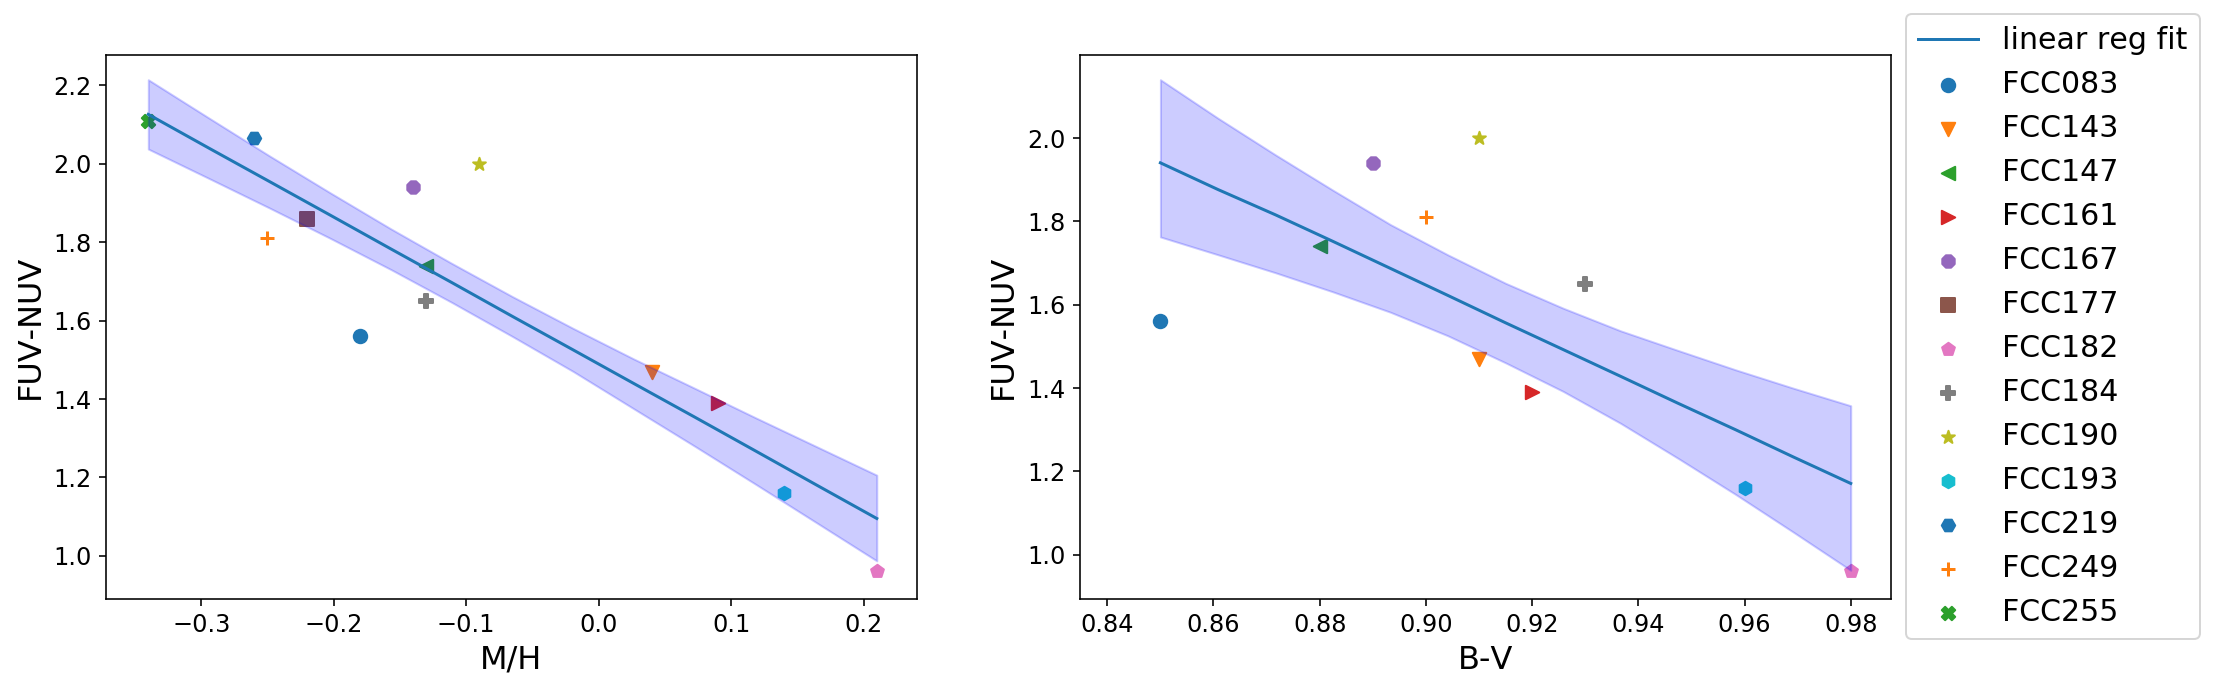

In [40]:
plt.figure(figsize=(16,5))
for n,item in enumerate(things_to_comp_m):
    ax = plt.subplot(1,2,n+1)
    for i, x_dat, y_dat in zip(gal_df[item].loc[FUV_filter].index, gal_df[item].loc[FUV_filter], gal_df["FUV-NUV"].loc[FUV_filter]):
        plt.scatter(x_dat, y_dat, marker=gal_df.loc[i, "marker"], s=45, label=gal_df.loc[i, "Galaxy"])
#     plt.scatter(gal_df[item].loc[FUV_filter], gal_df["FUV-NUV"].loc[FUV_filter], c="k")
    plt.ylabel("FUV-NUV", fontsize=font_s)
    plt.xlabel(item, fontsize=font_s)
    #plt.errorbar(gal_df[item].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=gal_df["FUV err"].loc[gal_df["PNe N"]>20], yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
    plt.tick_params(labelsize=label_s)
#     for i, name in enumerate(gal_df["Galaxy"].loc[PN_filter]):
#         ax.annotate(name, (gal_df[item].loc[gal_df["Galaxy"]==name]+0.01, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="k", size=10)
    plt.plot(lin_reg_m[n][3], lin_reg_m[n][0], label="linear reg fit",)
    plt.fill_between(lin_reg_m[n][3], lin_reg_m[n][1], lin_reg_m[n][2], alpha=0.2, color="b")
    
    if n == 1:
        plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=15)
#     plt.legend()

plt.savefig("Plots/FUV_minus_NUV_comp.png", bbox_inches='tight')

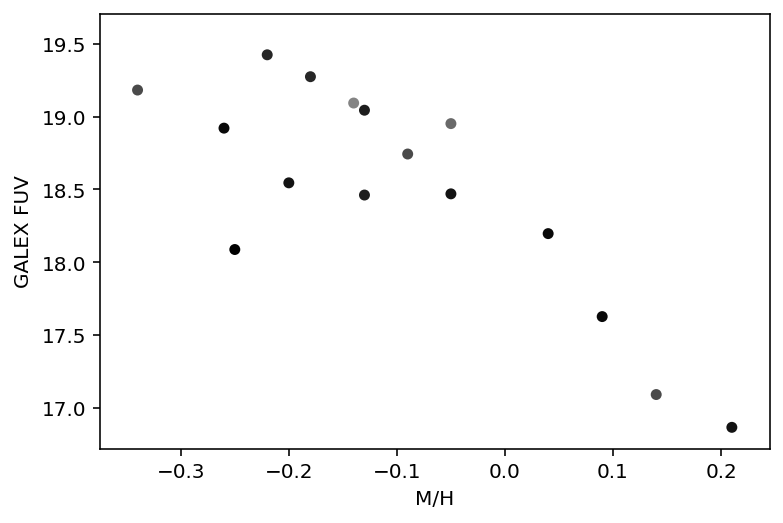

In [67]:
gal_df.plot(x="M/H", y="GALEX FUV", kind="scatter")

In [ ]:
f_size = 22
l_size = 15

plt.figure(figsize=(20,26))

ax1 = plt.subplot(4,2,1) # FUV
plt.scatter(gal_df["FUV"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel("FUV mag", fontsize=f_size)
plt.errorbar(gal_df["FUV"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=gal_df["FUV err"].loc[gal_df["PNe N"]>20], yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
plt.tick_params(labelsize=l_size)
#ax1.set_ylim(-8,-7)
#ax1 = plt.gca()
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax1.annotate(name, (gal_df["FUV"].loc[gal_df["Galaxy"]==name]+0.03, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="black", size=10)

# FUV - NUV
ax2 = plt.subplot(4,2,2) 
plt.scatter(gal_df["FUV-NUV"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.errorbar(gal_df["FUV-NUV"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=(gal_df["FUV err"].loc[gal_df["PNe N"]>20]**2+gal_df["NUV err"].loc[gal_df["PNe N"]>20]**2)**1/2, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
#plt.errorbar(B_FUV_m_V, Buzzoni_log_a-1, xerr=B_Vmag_err+B_FUV_err, yerr=0.08, c="r", ls="None", label=None)
plt.xlabel("FUV - NUV", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax2.annotate(name, (gal_df["FUV-NUV"].loc[gal_df["Galaxy"]==name]-0.02,  gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="black", size=10)

# FUV - V
ax3 = plt.subplot(4,2,3) 
plt.scatter(gal_df["FUV-V"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], label="F3D")
#plt.scatter(B_FUV_m_V, Buzzoni_log_a-1, c="r", label=r"Buzzoni 2006 $\alpha$")
plt.errorbar(gal_df["FUV-V"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=(gal_df["NUV err"].loc[gal_df["PNe N"]>20]**2+gal_df["Vmag err"].loc[gal_df["PNe N"]>20]**2)**1/2, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
#plt.errorbar(B_FUV_m_V, Buzzoni_log_a-1, xerr=B_Vmag_err+B_FUV_err, yerr=0.08, c="r", ls="None", label=None)
plt.xlabel("FUV - V (mag)", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
#plt.legend(fontsize=l_size, loc=2)
#plt.xlim(4,)
ax3.tick_params(labelsize=l_size)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax3.annotate(name, (gal_df["FUV-V"].loc[gal_df["Galaxy"]==name]-0.02,  gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="black", size=10)

# FUV - R
ax4 = plt.subplot(4,2,4) 
plt.scatter(gal_df["FUV-R"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.errorbar(gal_df["FUV-R"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=0.1, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
plt.xlabel("FUV - R (mag)", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax4.annotate(name, (gal_df["FUV-R"].loc[gal_df["Galaxy"]==name]-0.01, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="black", size=10)
    
# Rmag vs alpha
ax5 = plt.subplot(4,2,5)
plt.scatter(gal_df["Rmag"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel("R mag", fontsize=f_size)
plt.errorbar(gal_df["Rmag"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=0.1, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax5.annotate(name, (gal_df["Rmag"].loc[gal_df["Galaxy"]==name]-0.14, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="black", size=10)
    
ax6 = plt.subplot(4,2,6)
plt.scatter(gal_df["sigma"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$\sigma_{e} \ (km s^{-1})$ ", fontsize=f_size)
plt.errorbar(gal_df["sigma"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=9.0, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
plt.tick_params(labelsize=l_size)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax6.annotate(name, (gal_df["sigma"].loc[gal_df["Galaxy"]==name]-2.5, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.01), color="black", size=10)
    
    
ax7 = plt.subplot(4,2,7) # M/H metallicity
plt.scatter(gal_df["M/H"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.errorbar(gal_df["M/H"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=0.035, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$[M/H]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.tick_params(labelsize=l_size)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax7.annotate(name, (gal_df["M/H"].loc[gal_df["Galaxy"]==name]+0.01, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.003), color="black", size=10)
    
ax8 = plt.subplot(4,2,8)
plt.scatter(gal_df["Mg/Fe"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.errorbar(gal_df["Mg/Fe"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=0.01, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$[Mg/Fe]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.tick_params(labelsize=l_size)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax8.annotate(name, (gal_df["Mg/Fe"].loc[gal_df["Galaxy"]==name]+0.004, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.005), color="black", size=10)
    
plt.tight_layout()

#plt.savefig("Plots/Pandas_alpha_comparison_plots.pdf", bbox_inches='tight')
#plt.savefig("Plots/Pandas_PNLF_alpha_comparison_plots_filtered.png", bbox_inches='tight')
# plt.savefig("Plots/Pandas_PNLF_alpha_comparison_plots.png", bbox_inches='tight')
#plt.savefig("Plots/Pandas_lit_alpha_comparison_plots.png", bbox_inches='tight')
